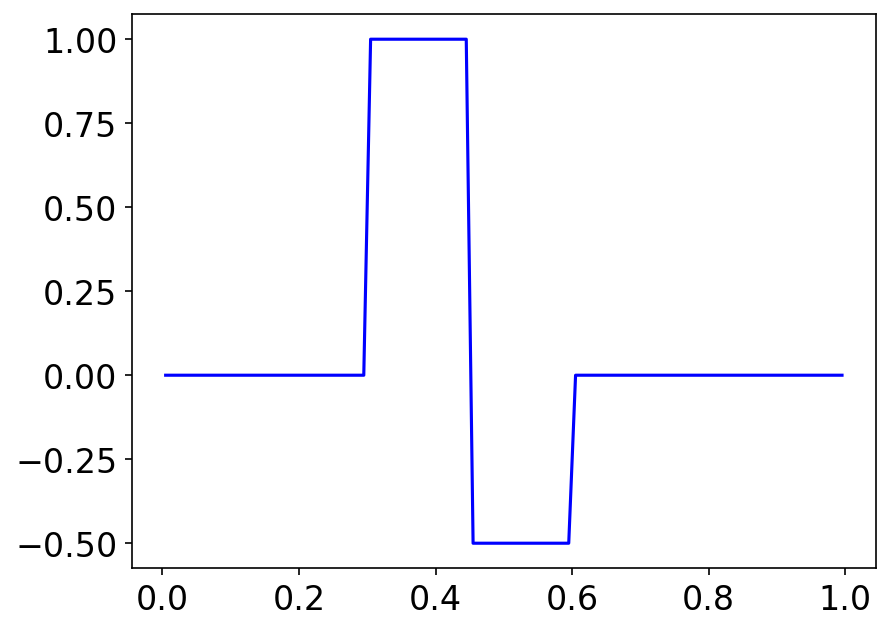

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 150

nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.cell_centers_x > 0.3] = 1.0
true_model[mesh.cell_centers_x > 0.45] = -0.5
true_model[mesh.cell_centers_x > 0.6] = 0

# Plotting the true model
plt.plot(mesh.cell_centers_x, true_model, "b-")

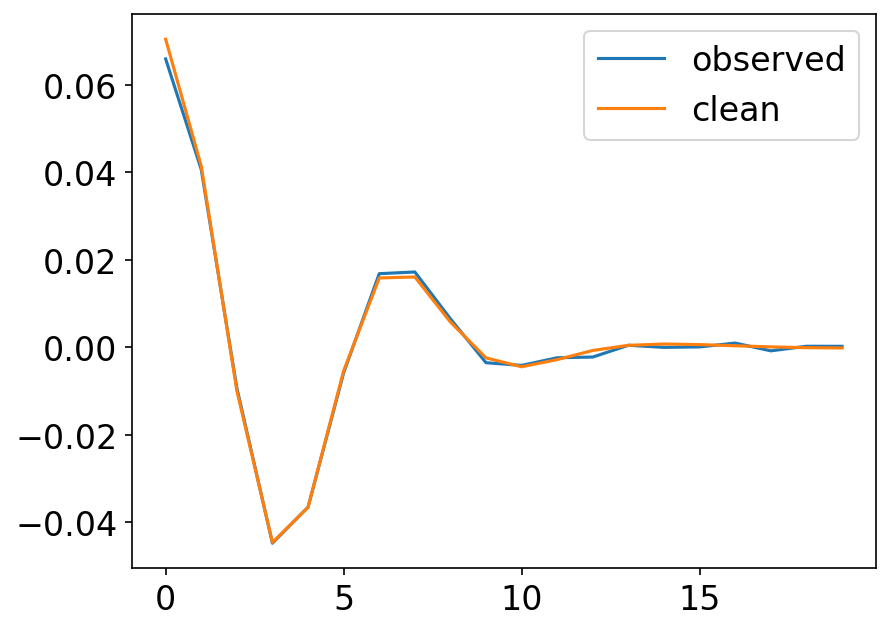

In [68]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial.
# The columns of the linear operator represents a set of decaying and oscillating functions.
sim = simulation.ExponentialSinusoidSimulation(
    model_map=maps.IdentityMap(), mesh=mesh, n_kernels=nData, p=-0.25, q=0.25, j0=1, jn=60
)
G = sim.G

# Standard deviation of Gaussian noise being added
data_std = 0.001
np.random.seed(3211)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, noise_floor=data_std, add_noise=True)

plt.plot(data_obj.dobs, label='observed')
plt.plot(data_obj.dclean, label='clean')
plt.legend()

3888.8673434670013 753.2177932338451
(100, 100) (100,)


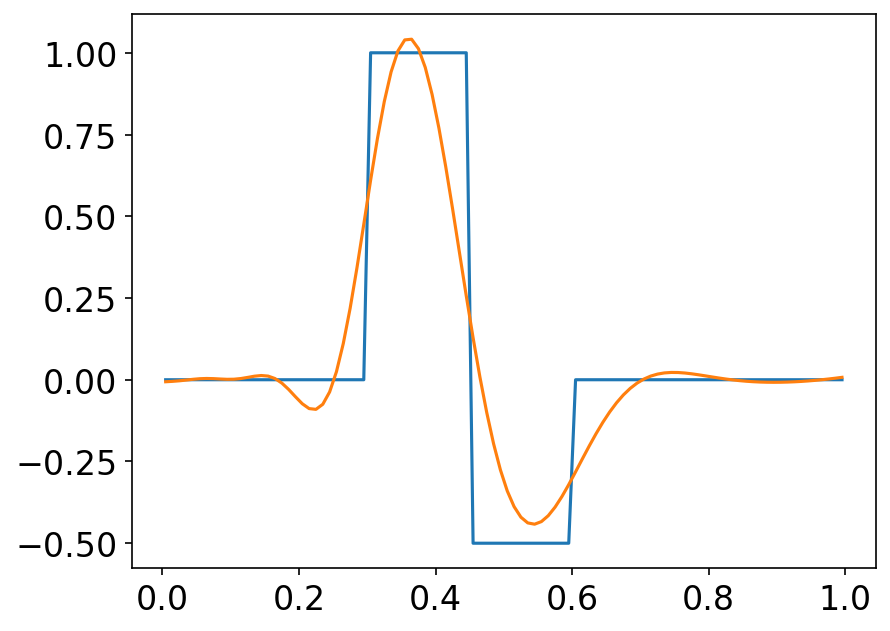

In [69]:
model_std = 0.4
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + 1/model_std**2 * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @  data_obj.dobs
print(np.linalg.norm(A), np.linalg.norm(b))
print(A.shape, b.shape)
m_max_post = np.linalg.solve(A, b)

del_d = Wd @ (G @ m_max_post - data_obj.dobs)
# print(del_d.T @ del_d)

plt.plot(mesh.cell_centers_x, true_model)
plt.plot(mesh.cell_centers_x, m_max_post)

plt.show()

# plt.hist((G.T @ Wd.T @ Wd @ data_obj.dobs).flatten())
# plt.show()
# plt.hist((1/model_std**2 * np.eye(G.shape[1])).flatten())

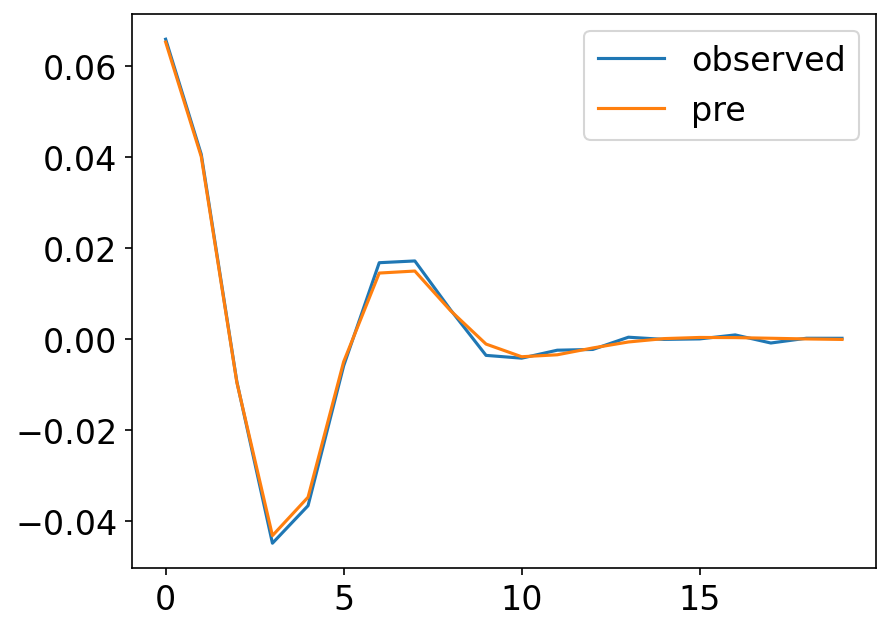

In [70]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(G @ m_max_post, label='pre')
plt.legend()

## Create the perturbed data distrubution

(20, 20) (1, 20)


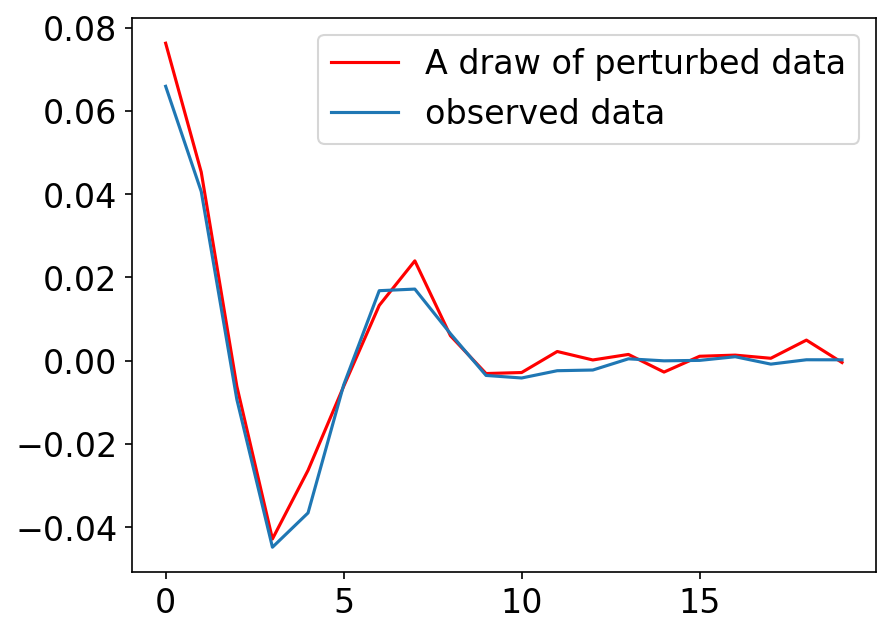

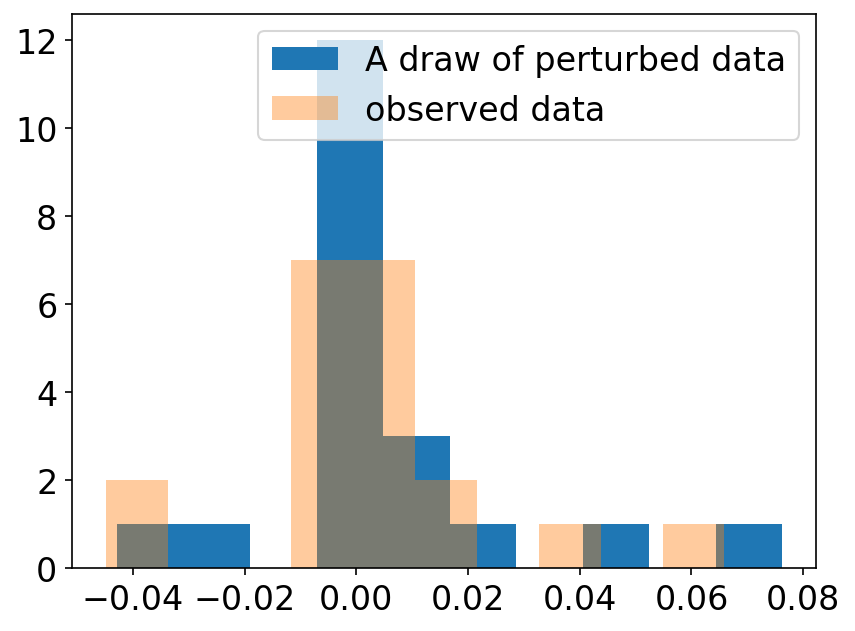

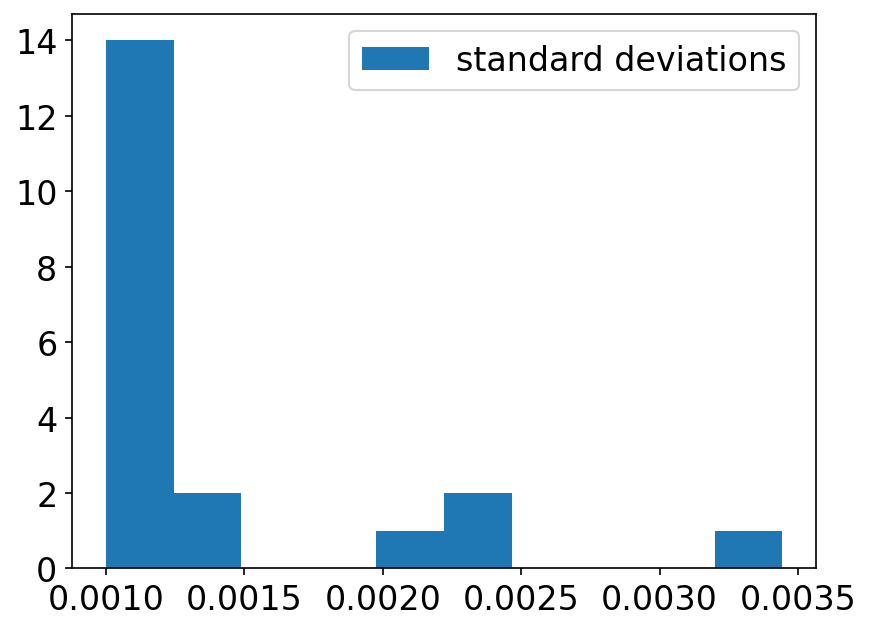

In [71]:
# Generate sample data
np.random.seed(0)

n_samples = 1000
n_components = 20
Wd = np.diag(data_obj.standard_deviation * 1e-2)

# Generate two Gaussian distribution
perturbed_data = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)

plt.plot(perturbed_data.T, 'r', label='A draw of perturbed data')
plt.plot(data_obj.dobs, label='observed data')
print(Wd.shape, perturbed_data.shape)
plt.legend()
plt.show()

plt.hist(perturbed_data.mean(axis=0), label='A draw of perturbed data')
plt.hist(data_obj.dobs, alpha=0.4, label='observed data')
plt.legend()
plt.show()

plt.hist(data_obj.standard_deviation, label='standard deviations')
plt.legend()
plt.show()

## create distrubution for perturbed model

(100, 100)
(1, 100) (100, 100)
(100, 1)


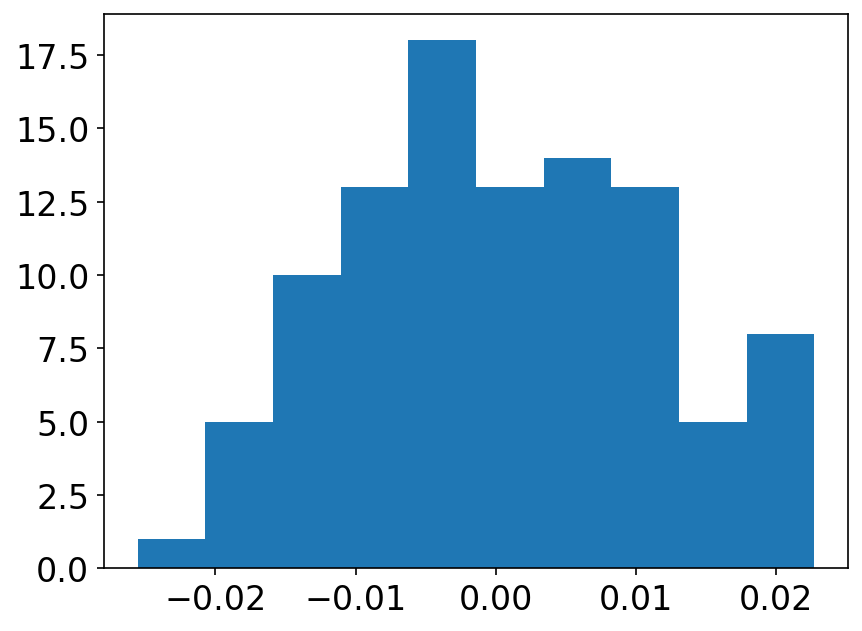

In [72]:
from scipy import linalg
mean = 0
mu = 1e4 #np.mean(data_obj.dobs)

identity_matrix = np.eye(100)
print(identity_matrix.shape)
zero_means = np.zeros(100)

s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

# coefficient matrix
Wm = np.sqrt(mu) * np.eye(100)
print(s.shape, Wm.shape)
perturbed_model = np.linalg.solve(Wm, s.T)
print(perturbed_model.shape)
plt.hist(perturbed_model)
plt.show()


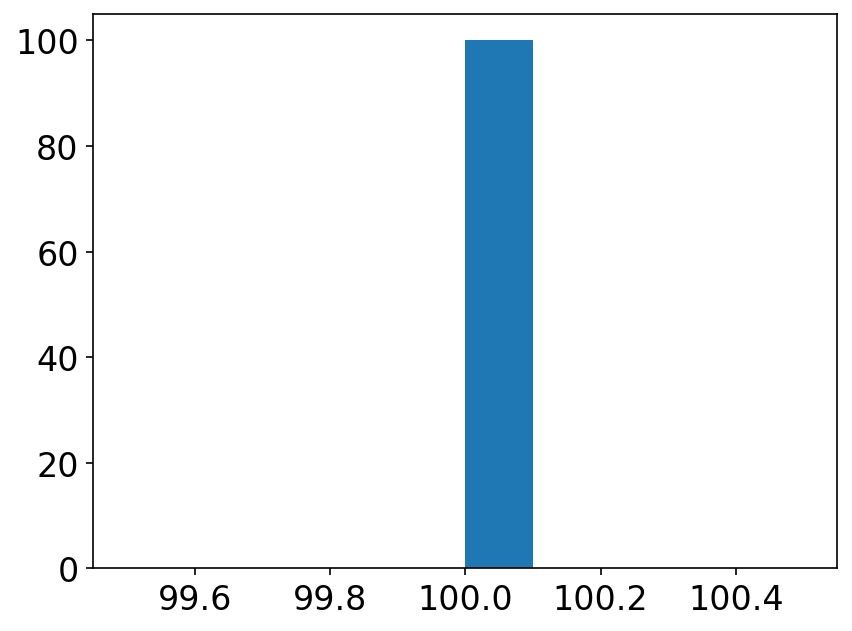

(100, 100)


In [82]:
plt.hist(Wm.diagonal())
plt.show()
print(Wm.shape)
# # draws = []

# Wm = linalg.inv(Wd)
# mu = 4.0
# Wd = np.diag(1/data_obj.standard_deviation)

# A = G.T @ Wd.T @ Wd @ G + mu * np.eye(G.shape[1])
# b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu * np.eye(G.shape[1]) @ perturbed_model


# # m_max_post = np.linalg.solve(A, b)
# draws = m_max_post
# draws = np.hstack(draws)
# print(A.shape, b.shape, (G.T @ Wd.T @ Wd @ perturbed_data.T).shape )
# plt.plot(draws)
# plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

# mu = 1e3
# A = G.T @ Wd.T @ Wd @ G
# b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu / 2


# m_max_post_l1 = np.linalg.solve(A, b)
# draws = m_max_post
# # draws = np.hstack(draws)
# print((G.T @ Wd.T @ Wd @ G).shape, (mu * np.eye(G.shape[1])).shape)
# # plt.plot(draws)
# # plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

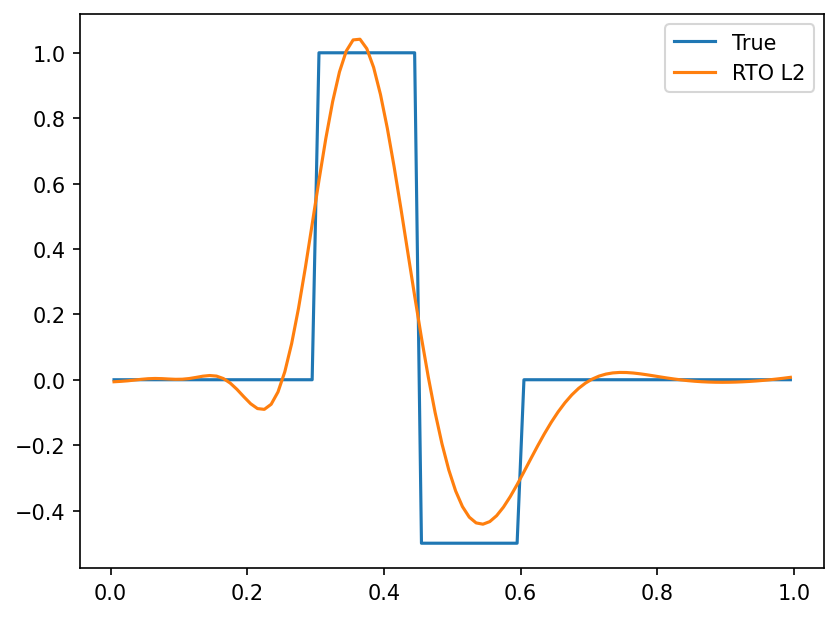

In [460]:
plt.plot(mesh.cell_centers_x, true_model, label='True')
plt.plot(mesh.cell_centers_x, draws, label='RTO L2')
# plt.plot(mesh.cell_centers_x, m_max_post_l1, label='RTOL1')
plt.legend()

## create function to perform rto-tko

In [13]:
def randomize_them_optimize(
        
        dobs:np.ndarray,
        n_samples:int=50,
        n_model_samples:int=100,
        n_components:int=20,
        mu_init:float=1e1,
        mu_perturb:float=1e4,
        standard_deviation:np.ndarray=None,
        TKO: bool=False,
        upper: float=np.inf,
        lower: float=-np.inf,
        
    ) -> np.ndarray:

    # Generate sample data
    np.random.seed(0)

    # data covariace matrix to perturb data
    Wd = np.diag(standard_deviation)

    # model zero mean guassian distribution
    identity_matrix = np.eye(n_model_samples)
    zero_means = np.zeros(n_model_samples)

    draws = []
    draws_mu = []

    for ii in range(n_samples):
    
        # draw from perturbed data distribution
        perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)

        # draw from perturbed model distribution
        s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

        # coefficient matrix
        Wm = np.sqrt(mu_perturb) * np.eye(n_model_samples)
        
        # solve linear equation for perturbed model
        perturbed_model = np.linalg.solve(Wm, s.T)

        # data covariance matrix
        Cd = np.diag(1 / standard_deviation)

        # solve for model
        A = G.T @ Cd.T @ Cd @ G + mu_init * np.eye(G.shape[1])
        b = G.T @ Cd.T @ Cd @ perturbed_data.T + mu_init * np.eye(G.shape[1]) @ perturbed_model
        m_max_post = np.linalg.solve(A, b)
        
        # sample from tradeoff parameter to find best regularization beta
        if TKO:
            perturbed_data2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
            mu_new = tko(G, perturbed_data2, Cd, m_max_post, mu_init)

            if lower < mu_new < upper:
                print(f"using mu: {mu_new} {mu_init}")
                draws_mu.append(mu_new[0])

        draws.append(m_max_post)
        
    # if TKO was selected send back the tradeoff parameter distribution
    if TKO:
        
        return np.hstack(draws), np.hstack(draws_mu) 
    
    return np.hstack(draws)

def tko(for_mat, perturbed_data_2, Cd, rto_model, mu_ref):

    G = for_mat.copy()
    initial_x = 20

    # Example usage with the function f(x) = x^2 - 4x + 4
    def objective_func(mu):
        r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
        return 0.5 * np.linalg.norm(r)

    def gradient_func(mu):
        A = rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model
        B = rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
        return np.sqrt(mu_ref / mu) * A - B

    def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x:float):
        x = initial_x

        for i in range(iterations):

            xprev = np.array([x]).copy()

            # get residual
            r = objective_func(x)

            # Calculate the gradient at the current point
            grad = gradient_func(x)

            Ag = G * grad
            alpha = (r*Ag).mean()/(Ag*Ag).mean()
            
            # Update x using the gradient and learning rate
            # update = learning_rate * grad
            # print(f"alpha: {alpha}")

            x -= learning_rate * alpha * grad

            value = objective_func(x)
            # print(f"r: {r}, f(x): {value}")
            # if r < value:
            #     x = xprev[0]
            #     x -= learning_rate * alpha * grad
                # return xprev[0]

            if np.isnan(value):
        
                return xprev[0]
            
            # if (value < 0):
        
            #     return xprev

            # Print the current iteration and the value of the objective function
            # print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        
        return x.copy()

    learning_rate = 1e-3
    iterations = 50

    result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
    # print("Final result: x =", result, mu_ref)

    return result

    
    

In [14]:
rto_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=10,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

tko_results, mu_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=100,
        n_model_samples=100,
        n_components=20,
        mu_init=40,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        TKO=True
        
)
print(f" mean: {mu_results.mean()}")
rto_tko_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=mu_results.mean(),
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

C:\Users\johnk\AppData\Local\Temp\ipykernel_3888\2016961555.py:76: RuntimeWarning: invalid value encountered in sqrt
  r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T


using mu: [[4.89459017]] 40
using mu: [[5.99712244]] 40
using mu: [[7.45758446]] 40
using mu: [[2.81515013]] 40
using mu: [[6.80618182]] 40
using mu: [[3.22412087]] 40
using mu: [[5.78999631]] 40
using mu: [[2.53464481]] 40
using mu: [[4.75485296]] 40
using mu: [[2.04852442]] 40
using mu: [[3.76769859]] 40
using mu: [[3.5988854]] 40
using mu: [[6.69235708]] 40
using mu: [[1.23512882]] 40
using mu: [[3.62135267]] 40
using mu: [[0.95846779]] 40
using mu: [[5.16112899]] 40
using mu: [[0.28237948]] 40
using mu: [[5.71508826]] 40
using mu: [[0.60415454]] 40
using mu: [[3.71737368]] 40
using mu: [[6.99318138]] 40
using mu: [[6.43821642]] 40
using mu: [[2.46703348]] 40
using mu: [[5.12089974]] 40
using mu: [[3.75134174]] 40
using mu: [[1.06451314]] 40
using mu: [[1.64591795]] 40
using mu: [[5.19226739]] 40
using mu: [[1.74634551]] 40
using mu: [[1.5191939]] 40
using mu: [[0.82212954]] 40
using mu: [[1.71516259]] 40
using mu: [[4.14683031]] 40
using mu: [[2.08220409]] 40
using mu: [[1.79808043

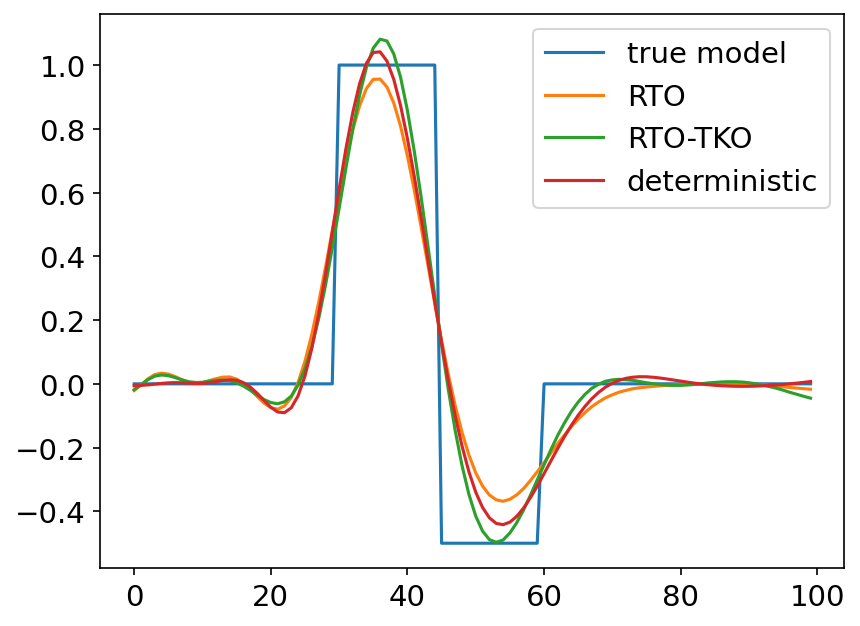

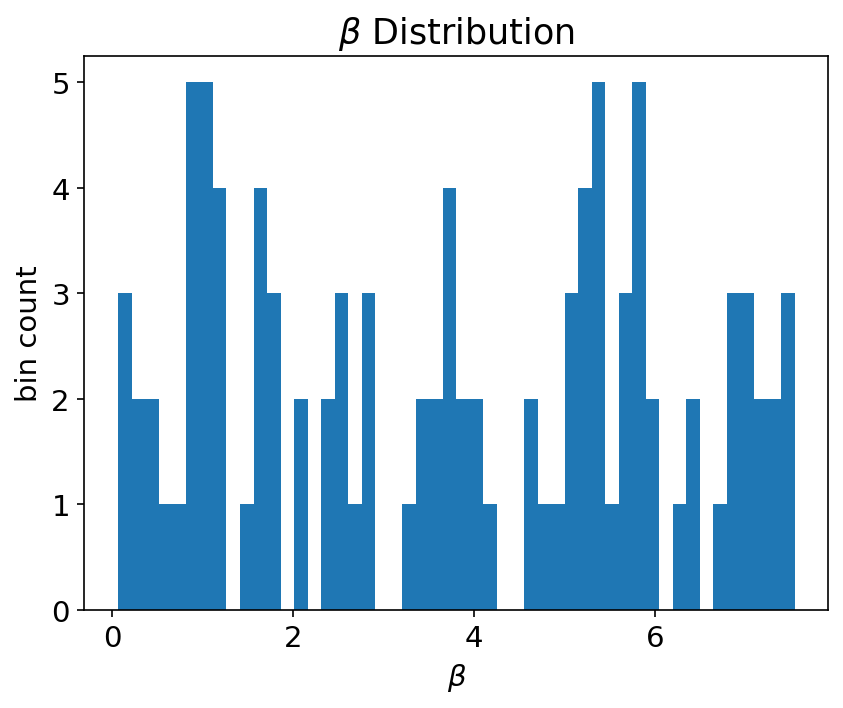

In [15]:
# print(results.shape)
plt.plot(true_model, label='true model')
plt.plot(rto_results.mean(axis=1), label='RTO')
plt.plot(rto_tko_results.mean(axis=1), label='RTO-TKO')
# plt.plot(rto_results[:, 1], label='RTO1')
# plt.plot(rto_results2.mean(axis=1), label='RTO2')
plt.plot(m_max_post, label='deterministic')
plt.legend()
plt.show()

plt.hist(mu_results.flatten(), 50)
plt.xlabel(r'$\beta$')
plt.ylabel('bin count')
plt.title(r'$\beta$ Distribution')
plt.show()

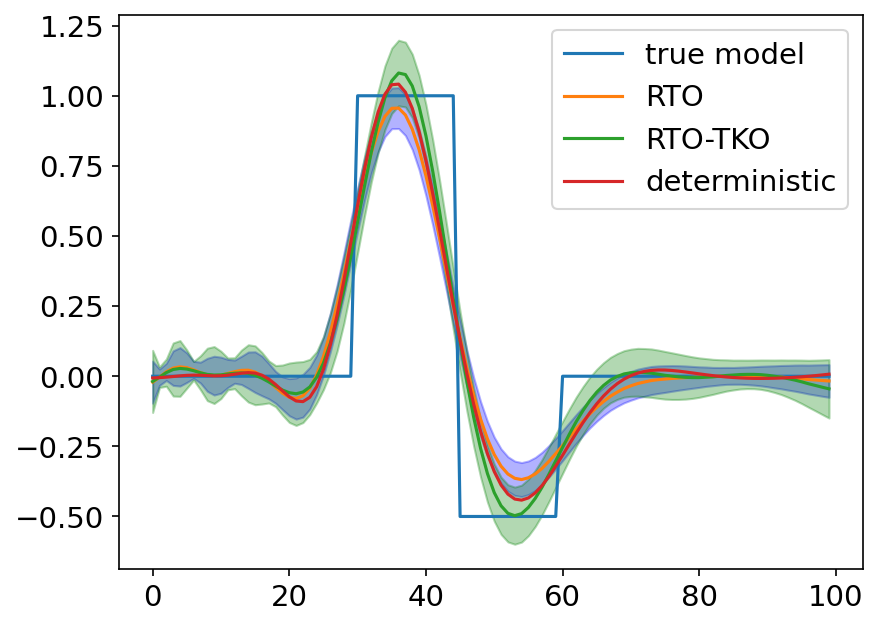

In [16]:
#some confidence interval
# print(results.shape)
y2 = rto_tko_results.mean(axis=1)
y = rto_results.mean(axis=1)
ci2 = []
for ii in range(100):
    ci2.append(1.96 * np.std(rto_tko_results[ii, :])/np.sqrt(rto_tko_results.shape[1]))

ci = []
for ii in range(100):
    ci.append(1.96 * np.std(rto_results[ii, :])/np.sqrt(rto_results.shape[1]))

plt.fill_between(np.arange(100), (y-ci), (y+ci), color='b', alpha=.3)
plt.fill_between(np.arange(100), (y2-ci2), (y2+ci2), color='g', alpha=.3)
plt.plot(true_model, label='true model')
plt.plot(rto_results.mean(axis=1), label='RTO')
plt.plot(rto_tko_results.mean(axis=1), label='RTO-TKO')
plt.plot(m_max_post, label='deterministic')
plt.legend()


17.952558562595993 37.04167022003964 16.789691205144642 323.3128691604149 362.589214595353


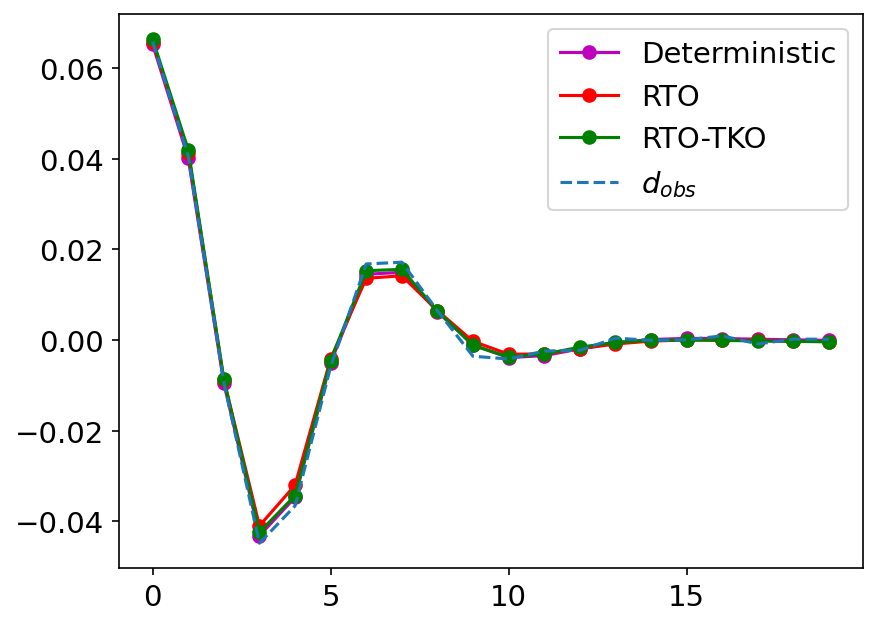

In [20]:
del_d = Wd @ (G @ rto_results.mean(axis=1) - data_obj.dobs)
del_d2 = Wd @ (G @ rto_tko_results.mean(axis=1) - data_obj.dobs)

Wm = np.sqrt(1e4) * np.eye(100)
del_m = Wm @ (rto_results.mean(axis=1) - np.zeros(100))
del_m2 = Wm @ (rto_tko_results.mean(axis=1) - np.zeros(100))
del_m3 = Wm @ (m_max_post - np.zeros(100))
print(np.sum(((G@m_max_post - data_obj.dobs)/ data_obj.standard_deviation)**2), np.sum(((G@rto_results.mean(axis=1) - data_obj.dobs)/ data_obj.standard_deviation)**2), np.sum(((G@rto_tko_results.mean(axis=1) - data_obj.dobs)/ data_obj.standard_deviation)**2), np.linalg.norm(del_m), np.linalg.norm(del_m2))

plt.plot(G @ m_max_post, 'o-m', label='Deterministic')
plt.plot(G @ rto_results.mean(axis=1), 'o-r', label='RTO')
plt.plot(G @ rto_tko_results.mean(axis=1), 'o-g', label='RTO-TKO')
plt.plot(data_obj.dobs, '--', label=r'$d_{obs}$')
plt.legend()

## TKO

In [166]:
1 / 0.00018

5555.555555555556

In [686]:
from scipy.sparse import spdiags
mu_ref = 1e1
mu_new = 1e3
mu_d = np.sqrt(mu_ref) / mu_ref
rto_model = results.mean(axis=1).T[:, None]
Wd = np.diag(data_obj.standard_deviation)
# perturbed data step 2
perturbed_data_2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
# print(mu_d, Wd.shape, G.shape, rto_model.shape, perturbed_data_2.shape, (rto_model @ rto_model.T).shape)
# # A =  G.T @ Wd.T @ Wd @ G @ spdiags(rto_model[:, 0], 0, 100, 100)
# A = G.T @ Wd.T @ Wd @ G @ rto_model
# b =  G.T @ Wd.T @ Wd @ perturbed_data_2.T
# print(A.shape, b.shape)
# m_max_post = mu_d * np.linalg.solve(A, b)

# plt.hist(m_max_post)
# print(m_max_post.mean())
Cd = np.diag(1 / data_obj.standard_deviation)

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(mu):
    r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
    # print(0.5 * np.linalg.norm(r))
    return 0.5 * np.linalg.norm(r)

def gradient_func(mu):
    A = rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model
    B = rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
    # print(G)
    # return np.sqrt(mu_ref / mu) * rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model - rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
    return np.sqrt(mu_ref / mu) * A - B

def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x):
    x = initial_x
    v = []
    v2 = []
    for i in range(iterations):

        xprev = np.array([x]).copy()

        # get residual
        r = objective_func(x)

        # Calculate the gradient at the current point
        grad = gradient_func(x)

        Ag = G * grad
        alpha = (r*Ag).mean()/(Ag*Ag).mean()
        
        # Update x using the gradient and learning rate
        # update = learning_rate * grad
        # print(f"update: {update} alpha: {alpha}")

        x -= learning_rate * alpha * grad

        value = objective_func(x)
        
        # if r<  value:
        #     return xprev[0]
        #     x = xprev[0]
        #     x += learning_rate * alpha * grad

        if np.isnan(value):
    
            return xprev[0]

        # plt.plot(v, v2, '.')
        
        # Print the current iteration and the value of the objective function
        print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        v.append(x[0].copy())
        v2.append(value)

    plt.plot(v, v2, '-o')

    plt.show()
    
    return x

learning_rate = 1e-3
iterations = 50
initial_x = 30

result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
print("Final result: x =", result, mu_ref)

A = G.T @ Cd.T @ Cd @ G + result * np.eye(G.shape[1])
b = G.T @ Cd.T @ Cd @ perturbed_data.T + result * np.eye(G.shape[1]) @ perturbed_model
m_max_post_t = np.linalg.solve(A, b)
# plt.plot(m_max_post_t)
# pts = []
# for m_ in np.arange(0.1, 10, 0.1):
#     pts.append(objective_func(m_))
# plt.plot(np.arange(0.1, 10, 0.1), pts)
# plt.show()
# print(gradient_func(initial_x))

Iteration 1: x = [[25.01152696]], f(x) = 72.8054347839024
Iteration 2: x = [[20.02042979]], f(x) = 72.8857520406171
Iteration 3: x = [[15.02382656]], f(x) = 73.06244881771191
Iteration 4: x = [[10.01511007]], f(x) = 73.51604601170718
Iteration 5: x = [[4.97529772]], f(x) = 75.26593055867734
Final result: x = [[4.97529772]] 10.0


C:\Users\johnk\AppData\Local\Temp\ipykernel_10548\1885732839.py:22: RuntimeWarning: invalid value encountered in sqrt
  r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T


In [500]:
mu_ref / mu

2.5

# Set up a DC simulation

overwriting c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr1d.tar.gz
   saved to: c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr1d.tar.gz
Download completed!


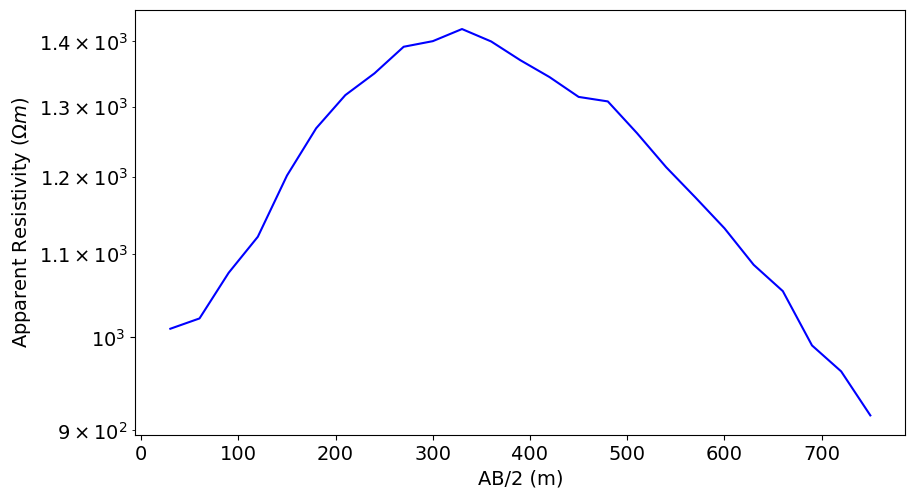

In [81]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model

mpl.rcParams.update({"font.size": 16})

# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/dcr1d.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
data_filename = dir_path + "app_res_1d_data.dobs"

# Load data
dobs = np.loadtxt(str(data_filename))

A_electrodes = dobs[:, 0:3]
B_electrodes = dobs[:, 3:6]
M_electrodes = dobs[:, 6:9]
N_electrodes = dobs[:, 9:12]
dobs = dobs[:, -1]

# Define survey
unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.sort(k)
k = np.r_[k, len(k) + 1]

source_list = []
for ii in range(0, n_sources):
    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [
        dc.receivers.Dipole(
            M_locations,
            N_locations,
            data_type="apparent_resistivity",
        )
    ]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

# Plot apparent resistivities on sounding curve as a function of Wenner separation
# parameter.
electrode_separations = 0.5 * np.sqrt(
    np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
)

fig = plt.figure(figsize=(11, 5))
mpl.rcParams.update({"font.size": 14})
ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.85])
ax1.semilogy(electrode_separations, dobs, "b")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.show()

### Deterministic


  TensorMesh: 26 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     26          0.00        546.90      5.00     50.00    1.10



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.26e+01  2.16e+04  0.00e+00  2.16e+04    1.79e+03      0              
   1  1.26e+01  1.64e+03  1.00e+02  2.91e+03    1.86e+03      1              
   2  1.26e+01  1.16e+02  1.31e+02  1.76e+03 

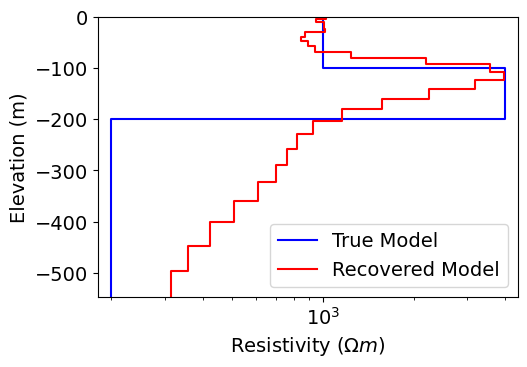

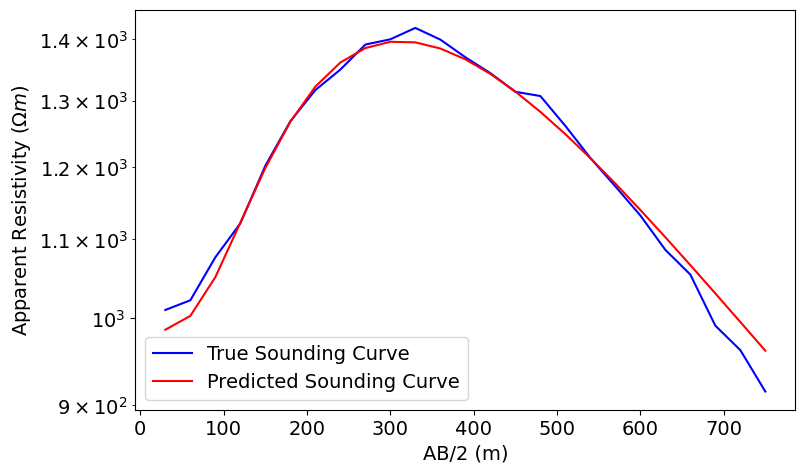

In [82]:
std = 0.02 * np.abs(dobs)

data_object = data.Data(survey, dobs=dobs.copy(), standard_deviation=std)

# Define layer thicknesses
layer_thicknesses = 5 * np.logspace(0, 1, 25)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

print(mesh)

# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh, alpha_s=1.0, alpha_x=1.0, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model_deterministic = inv.run(starting_model)

# Define true model and layer thicknesses
true_model = np.r_[1e3, 4e3, 2e2]
true_layers = np.r_[100.0, 100.0]

# Plot true model and recovered model
fig = plt.figure(figsize=(6, 4))
x_min = np.min([np.min(model_map * recovered_model_deterministic), np.min(true_model)])
x_max = np.max([np.max(model_map * recovered_model_deterministic), np.max(true_model)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model_deterministic,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(electrode_separations, dobs, "b")
ax1.semilogy(electrode_separations, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()

### RTO

(25,) (25,)


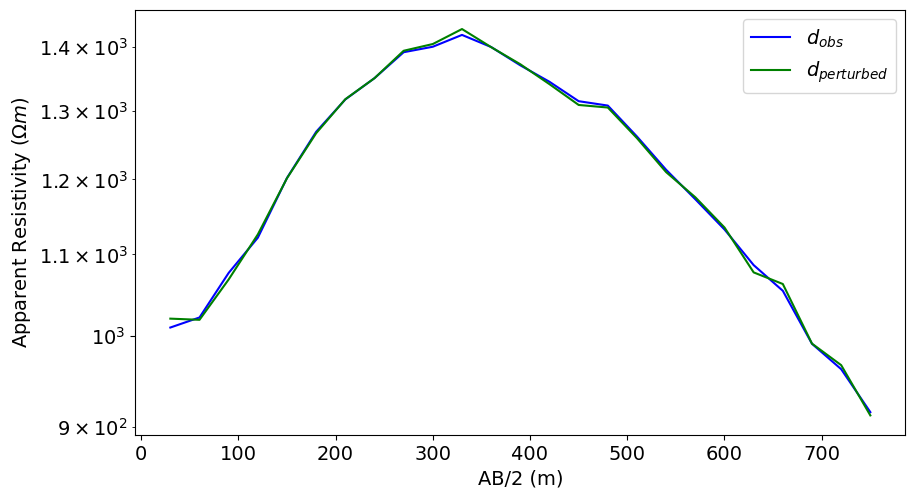

In [118]:
std = 0.02 * dobs
n_model_samples = 26
beta_perturb = 1e5

Wd = np.diag(std)

perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
print(dobs.shape, perturbed_data.shape)


fig = plt.figure(figsize=(11, 5))
mpl.rcParams.update({"font.size": 14})
ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.85])
ax1.semilogy(electrode_separations, dobs, "b", label=r'$d_{obs}$')
ax1.semilogy(electrode_separations, perturbed_data, "g", label=r'$d_{perturbed}$')
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()

# data_object_rto = data.Data(survey, dobs=perturbed_data, standard_deviation=std)

# # Define layer thicknesses
# layer_thicknesses = 5 * np.logspace(0, 1, 25)

# # Define a mesh for plotting and regularization.
# mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

# print(mesh)

# # Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
# starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

# # Define mapping from model to active cells.
# model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

# simulation = dc.simulation_1d.Simulation1DLayers(
#     survey=survey,
#     rhoMap=model_map,
#     thicknesses=layer_thicknesses,
# )




In [71]:
print(1 / 2e2 * np.ones((len(layer_thicknesses) + 1)))

[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005]


In [84]:
import numpy as np
results = np.load(r"C:\Users\johnk\Documents\git\jresearch\rto_models.npy")

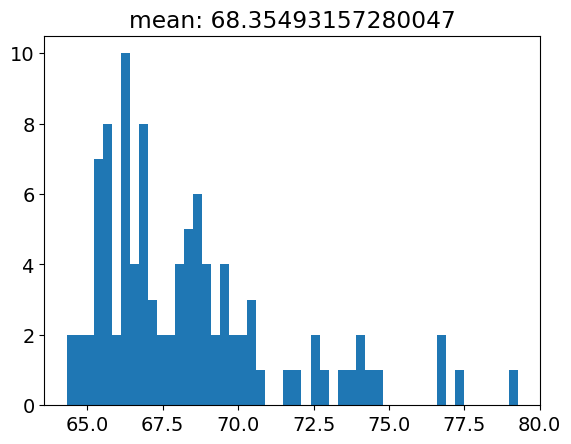

In [12]:
plt.hist(draws_beta, 50)
plt.title(f'mean: {np.mean(draws_beta)}')
plt.show()


In [148]:
# ii = 0
# rto_tko_results = [None] * 100
# while ii < 100:

#     perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
#     data_object = data.Data(survey, dobs=perturbed_data, standard_deviation=std)

#     s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)
#     perturbed_model = np.linalg.solve(Wm, s.T)

#     # Define the data misfit. Here the data misfit is the L2 norm of the weighted
#     # residual between the observed data and the data predicted for a given model.
#     # Within the data misfit, the residual between predicted and observed data are
#     # normalized by the data's standard deviation.
#     dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

#     # Define the regularization (model objective function)
#     # reg_rto = regularization.WeightedLeastSquares(
#     #     mesh, alpha_s=1e-2, alpha_x=1, reference_model=perturbed_model[:, 0]
#     # )
#     reg_rto = regularization.Sparse(
#         mesh, alpha_s=1, alpha_x=1e-2, reference_model=perturbed_model[:, 0]
#     )

#     # rto_model = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)

#     # Optimization
#     opt = optimization.ProjectedGNCG(maxIter=9, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=12, )
#     opt.remember('xc')

#     # Set the inverse problem
#     invProb = inverse_problem.BaseInvProblem(dmis_rto,  reg_rto,  opt)
#     invProb.startup(initial_x)
#     invProb.beta = 1e-10

#     rto_tko_results[ii] = opt.minimize(invProb.evalFunction, initial_x)

#     ii += 1

results = np.load(r"C:\Users\johnk\Documents\git\jresearch\rto_models_2d.npy", allow_pickle=True)

-15.0 15 -15.0 0.0


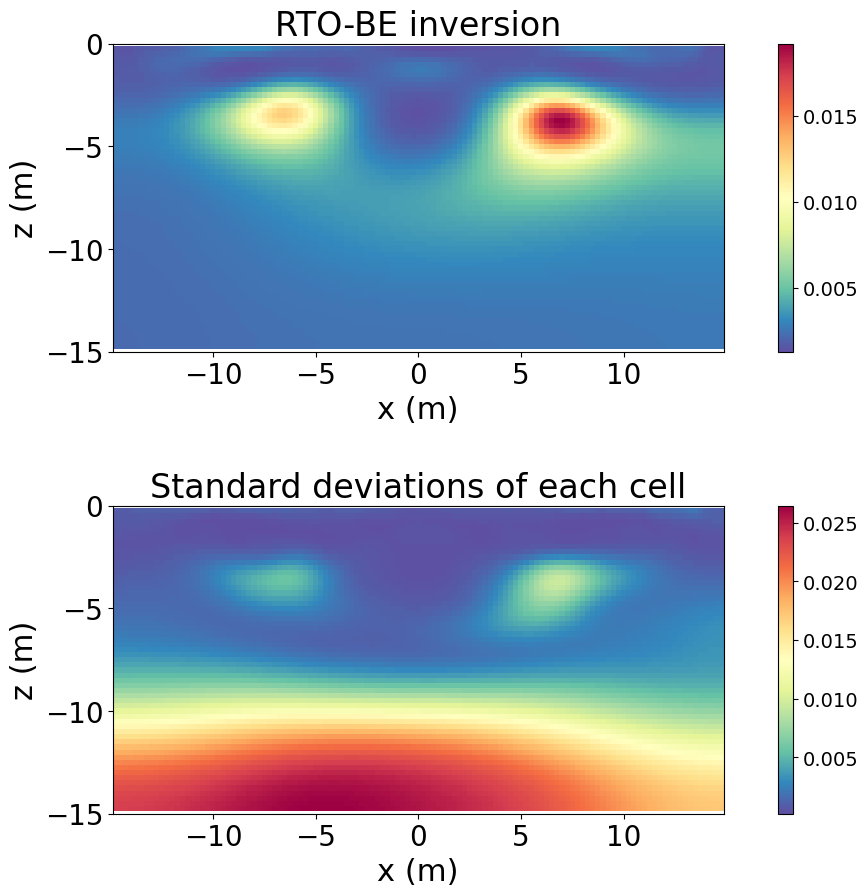

In [178]:
import discretize
import copy
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

# mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
# mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
# mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
#     norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
# mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
#     norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0



# mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.extract_core_mesh(xyzlim, mesh)

fig, ax = plt.subplots(2,1,figsize=(15,10))
dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
ax[0].set_title('RTO-BE inversion',fontsize=24)
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlabel('x (m)',fontsize=22)
ax[0].set_ylabel('z (m)',fontsize=22)
ax[0].tick_params(labelsize=20)
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0])

dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(results)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
ax[1].set_title('Standard deviations of each cell',fontsize=24)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
fig.subplots_adjust(right=0.85, hspace=0.5)
plt.colorbar(dat2[0])

plt.show()

### HMC

In [138]:
data_object_hmc = data.Data(survey, dobs=dobs.copy(), standard_deviation=std)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_hmc = data_misfit.L2DataMisfit(simulation=simulation, data=data_object_hmc)

beta_init = 1

# Define the regularization (model objective function)
reg_hmc = regularization.WeightedLeastSquares(
    mesh, alpha_s=1e-4, alpha_x=1, reference_model=starting_model
)

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(x):
    # print(dmis(x).shape, beta_init, reg(x).shape)
    phi = dmis_hmc(x) + beta_init * reg_hmc(x)
    return phi

def gradient_func(x):
    # dmis.test(x)
    return dmis_hmc.deriv(x) + beta_init * reg_hmc.deriv(x)

from scipy import stats

def hmc(neg_log_func, d_neg_log_func, n_samples, x0, n_leap_frog=4 ,step_size=0.25, p_std=1):

    samples = [x0, ]
    M = np.diag(p_std**2 * np.ones_like(x0))
    momentum_dist = stats.multivariate_normal(mean=np.zeros_like(x0), cov=M)
    M_inv = 1/p_std**2 * np.ones_like(x0)
    
    n_accept = 0 
    # deriv = d_neg_log_func(samples[0])
    x0_nlp = neg_log_func(samples[0])
    for i in range(n_samples):
        x0 = samples[-1]
        x1 = x0.copy()
        
        p0 = momentum_dist.rvs()
        p1 = p0.copy()

        # leapfrog integration begin
        deriv = d_neg_log_func(x1)
                                        
        # print(f'\n\nstarting to integrate: {i}\n\n')
        for s in range(n_leap_frog):
            p1 -= step_size * deriv/2
            x1 += step_size * M_inv * p1
            deriv = d_neg_log_func(x1)
            p1 -= step_size * deriv/2
        # leapfrog integration end
        p1 *= -1
        # reverse momentum at the final location for reversibility
        # In this case the momentum distribution is symmetric, so it doesn't matter...

        #metropolis acceptance
        x1_nlp = neg_log_func(x1)
        
        p0_nlp = -momentum_dist.logpdf(p0)
        p1_nlp = -momentum_dist.logpdf(p1)
        
        # Account for negatives AND log(probabiltiies)...
        target = x0_nlp - x1_nlp # f(x1)/f(x0)
        adjustment = p0_nlp - p1_nlp # g(p1)/g(p0)
        acceptance = target + adjustment # rf * rg
        
        if np.log(np.random.random()) <= acceptance:
            # print(f'accepted: {acceptance}')
            samples.append(x1)
            x0_nlp = x1_nlp
            n_accept += 1
        else:
            samples.append(x0)

    return np.array(samples), n_accept

samples, n_accept = hmc(
    objective_func, gradient_func, n_samples=20000, x0=starting_model, n_leap_frog=15 ,step_size=0.0001, p_std=0.1
)
print(n_accept)
hmc_result = samples

19496


In [109]:
# recovered_model = np.vstack(hmc_result).mean(axis=0)
print(hmc_result)

# dmis_hmc.test(starting_model)
# plt.hist(dmis_hmc.deriv(starting_model))

[[5.29831737 5.29831737 5.29831737 5.29831737 5.29831737 5.29831737
  5.29831737 5.29831737 5.29831737 5.29831737 5.29831737 5.29831737
  5.29831737 5.29831737 5.29831737 5.29831737 5.29831737 5.29831737
  5.29831737 5.29831737 5.29831737 5.29831737 5.29831737 5.29831737
  5.29831737 5.29831737]
 [5.29846404 5.29833544 5.29839379 5.2982242  5.2984794  5.29845116
  5.29842156 5.298256   5.29839689 5.29838314 5.29849719 5.29830634
  5.29820905 5.29862413 5.29850056 5.2981402  5.29844624 5.29831695
  5.29816327 5.2982492  5.2985073  5.29832849 5.29827365 5.29851212
  5.29834923 5.29833674]
 [5.29827541 5.29821933 5.29852719 5.29832977 5.29849396 5.29840574
  5.29854926 5.2983885  5.29833514 5.2984034  5.29853959 5.29822768
  5.29815775 5.29871434 5.29853482 5.29807594 5.29850162 5.29813342
  5.29807749 5.29810362 5.29850712 5.29818234 5.29836902 5.2984958
  5.29822106 5.29842155]
 [5.29813808 5.2982957  5.29873262 5.2983778  5.29848076 5.29851479
  5.29836315 5.29842284 5.29837586 5.29837

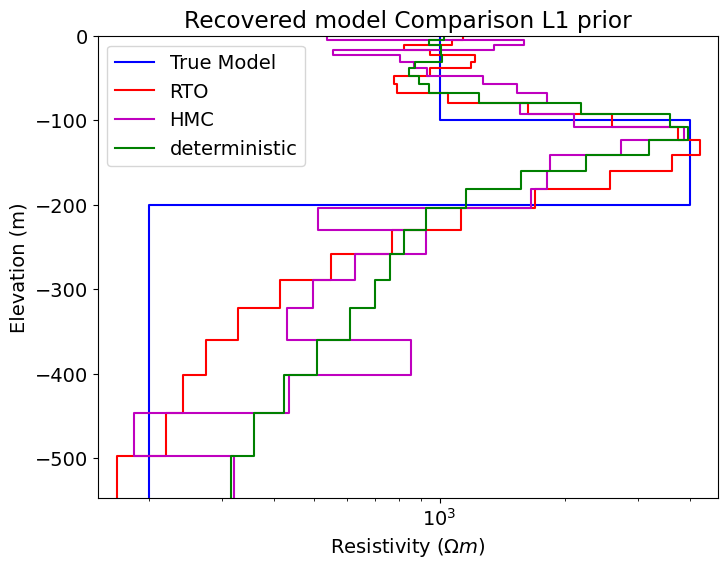

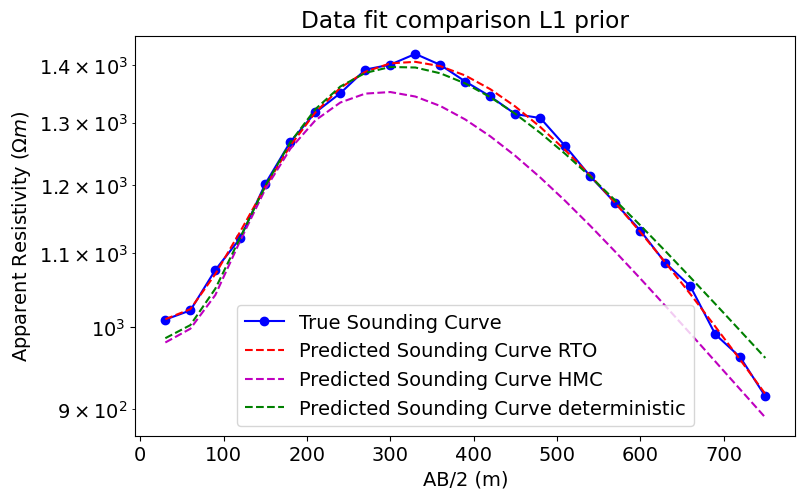

In [137]:
# print(np.hstack(result).shape)
recovered_model = np.vstack(results).mean(axis=0)
recovered_model_hmc = np.vstack(hmc_result).mean(axis=0)
#  Define true model and layer thicknesses
# true_model = np.r_[1e3, 4e3, 2e2]
# true_layers = np.r_[50.0, 50.0]

# Plot true model and recovered model
x_min = np.min([np.min(model_map * recovered_model), np.min(true_model)])
x_max = np.max([np.max(model_map * recovered_model), np.max(true_model)])

# rto_results = np.vstack(results)
# y = rto_results.mean(axis=0)
# ci = []
# for ii in range(rto_results.shape[1]):
#     ci.append(1.96 * np.std(rto_results[:, ii])/np.sqrt(rto_results.shape[1]))

# plt.fill_between(layer_thicknesses, (y-ci)[:-1], (y+ci)[:-1], color='b', alpha=.3)
# plt.plot(layer_thicknesses, recovered_model[:-1])
# plt.show()

# fig = plt.figure(figsize=(8, 6))
fig, ax1 = plt.subplots(1, figsize=(8, 6))
plot_1d_layer_model(true_layers, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model_hmc,
    ax=ax1,
    plot_elevation=True,
    color="m",
)
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model_deterministic,
    ax=ax1,
    plot_elevation=True,
    color="g",
)


ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.legend(["True Model", "RTO", "HMC", "deterministic"])
ax1.set_title("Recovered model Comparison L1 prior")
# plt.legend()
plt.show()

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(electrode_separations, dobs, "-ob")
ax1.semilogy(electrode_separations, simulation.dpred(np.vstack(results).mean(axis=0)), "--r")
ax1.semilogy(electrode_separations, dmis_hmc.simulation.dpred(np.vstack(hmc_result).mean(axis=0)), "--m")
ax1.semilogy(electrode_separations, inv_prob.dpred, "--g")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.set_title("Data fit comparison L1 prior")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve RTO", "Predicted Sounding Curve HMC", "Predicted Sounding Curve deterministic"])
plt.show()

In [19]:
identity_matrix = np.eye(100)
zero_means = np.zeros(100)
s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)
print(zero_means.shape, identity_matrix.shape, s.shape)

(100,) (100, 100) (1, 100)


$$
\mathbf{J}^{\top} \mathbf{W}^{\top} \mathbf{W}
            (\mathbf{d} - \mathbf{d}^{obs})

$$

$$
r(m) = \frac{1}{2}(\mathbf{m} - \mathbf{m_ref})^\top \mathbf{V}^T
            \mathbf{W}^T
        \mathbf{W} \mathbf{V} (\mathbf{m} - \mathbf{m_{ref}})
$$

## 3D RTO

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TreeMesh
from discretize.utils import refine_tree_xyz, active_from_xyz

from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip_xyz
from SimPEG import (
    data,
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
)

# To plot DC/IP data in 3D, the user must have the plotly package
try:
    import plotly
    from SimPEG.electromagnetics.static.utils.static_utils import plot_3d_pseudosection

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})

# sphinx_gallery_thumbnail_number = 3

# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/dcr3d.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_xyz.txt"
dc_data_filename = dir_path + "dc_data.xyz"

topo_xyz = np.loadtxt(str(topo_filename))

dc_data = read_dcip_xyz(
    dc_data_filename,
    "volt",
    data_header="V/A",
    uncertainties_header="UNCERT",
    is_surface_data=False,
)

# Convert predicted data to apparent conductivities
apparent_conductivity = 1 / apparent_resistivity_from_voltage(
    dc_data.survey,
    dc_data.dobs,
)

if has_plotly:
    fig = plot_3d_pseudosection(
        dc_data.survey,
        apparent_conductivity,
        scale="log",
        units="S/m",
        plane_distance=15,
    )

    fig.update_layout(
        title_text="Apparent Conductivity",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    plotly.io.show(fig)

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

dc_data.standard_deviation = 0.1 * np.abs(dc_data.dobs)

dh = 25.0  # base cell width
dom_width_x = 6000.0  # domain width x
dom_width_y = 6000.0  # domain width y
dom_width_z = 4000.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Mesh refinement based on topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh = refine_tree_xyz(
    mesh, topo_xyz[k, :], octree_levels=[0, 6, 8], method="surface", finalize=False
)

# Mesh refinement near sources and receivers.
electrode_locations = np.r_[
    dc_data.survey.locations_a,
    dc_data.survey.locations_b,
    dc_data.survey.locations_m,
    dc_data.survey.locations_n,
]
unique_locations = np.unique(electrode_locations, axis=0)
mesh = refine_tree_xyz(
    mesh, unique_locations, octree_levels=[4, 6, 4], method="radial", finalize=False
)

# Finalize the mesh
mesh.finalize()

# Find cells that lie below surface topography
ind_active = active_from_xyz(mesh, topo_xyz)

# Extract survey from data object
dc_survey = dc_data.survey

# Shift electrodes to the surface of discretized topography
dc_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

# Reset survey in data object
dc_data.survey = dc_survey

# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = np.log(1e-8)
background_conductivity = np.log(1e-2)

# Define the mapping from active cells to the entire domain
active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())

# Define the mapping from the model to the conductivity of the entire domain
conductivity_map = active_map * maps.ExpMap()

# Define starting model
starting_conductivity_model = background_conductivity * np.ones(nC)

dc_simulation = dc.simulation.Simulation3DNodal(
    mesh, survey=dc_survey, sigmaMap=conductivity_map, solver=Solver, storeJ=True
)

overwriting c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr3d.tar.gz
   saved to: c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr3d.tar.gz
Download completed!


In [85]:
class betaInvProblem(inverse_problem.BaseInvProblem):

    def evalFunction(self, m, return_g=True, return_H=True):
        """evalFunction(m, return_g=True, return_H=True)"""

        self.model = m
        gc.collect()

        # Store fields if doing a line-search
        f = self.getFields(m, store=(return_g is False and return_H is False))

        # if isinstance(self.dmisfit, BaseDataMisfit):
        tko_d = self.dmisfit(m, f=f)
        self.dpred = self.get_dpred(m, f=f)

        beta_prior = self.reg(m)

        phi = tko_d + beta_prior

        out = (phi,)
        if return_g:
            phi_dDeriv = self.dmisfit.deriv(m, f=f)
            phi_mDeriv = self.reg.deriv(m)

            g = phi_dDeriv + phi_mDeriv
            out += (g,)

        if return_H:

            def H_fun(v):
                phi_d2Deriv = self.dmisfit.deriv2(m, v, f=f)
                phi_m2Deriv = self.reg.deriv2(m, v=v)

                return phi_d2Deriv + phi_m2Deriv

            H = sp.linalg.LinearOperator((m.size, m.size), H_fun, dtype=m.dtype)
            out += (H,)
        return out if len(out) > 1 else out[0]

class L2BetaMisfit(data_misfit.BaseDataMisfit):
    r"""
    The data misfit with an l_2 norm:

    .. math::

        \mu_\text{data} =
            \frac{1}{2}
            \left|
                \mathbf{W}_d (\mathbf{d}_\text{pred} - \mathbf{d}_\text{obs})
            \right|_2^2
    """

    # @timeIt
    def __call__(self, beta, f=None):
        "__call__(m, f=None)"

        xi = np.sqrt(self.beta_ref / beta) * self.m
        R = self.W * self.residual(xi, f=f)
        return 0.5 * np.vdot(R, R)

    # @timeIt
    def deriv(self, beta, f=None):
        r"""
        Derivative of the data misfit

        .. math::

            \mathbf{J}^{\top} \mathbf{W}^{\top} \mathbf{W}
            (\mathbf{d} - \mathbf{d}^{obs})

        :param numpy.ndarray m: model
        :param SimPEG.fields.Fields f: fields object
        """
        print(self.beta_ref , beta)
        xi = np.sqrt(self.beta_ref / beta) * self.m
        d_xi = -0.5 * np.sqrt(self.beta_ref) * np.sqrt(beta)**-3 * self.m

        if f is None:
            f = self.simulation.fields(xi)

        return self.simulation.Jtvec(
            xi, self.W.T * (self.W * self.residual(xi, f=f)), f=f
        ) * d_xi

# identity_matrix = np.eye(100)
# zero_means = np.zeros(100)
# s = np.random.normal(zero_means, identity_matrix, size=1)
# perturbed_model = np.linalg.solve(Wm, s.T)

(34988, 1) (34988, 34988)


C:\Users\johnk\AppData\Local\Temp\ipykernel_14432\1024693067.py:49: RuntimeWarning:

covariance is not positive-semidefinite.



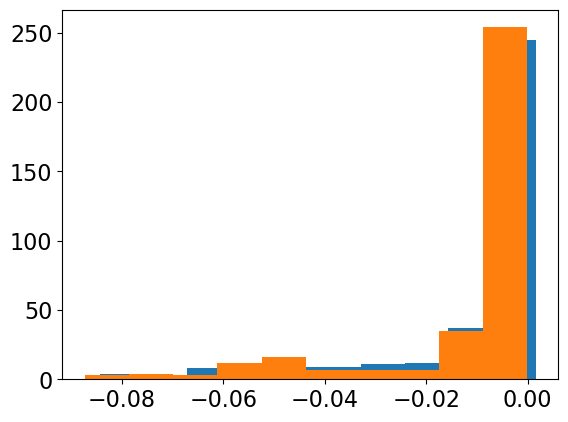

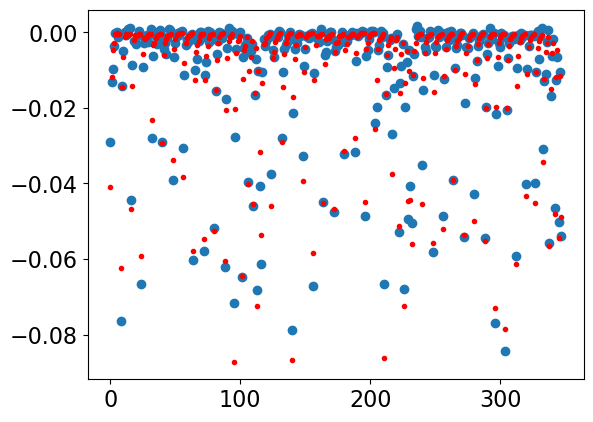

C:\Users\johnk\AppData\Local\Temp\ipykernel_14432\1024693067.py:75: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  1.40e+08    4.83e+06      0              
   1  8.96e+04    7.14e+03      0              
   2  3.72e+04    1.00e+02      0   Skip BFGS  
   3  3.61e+04    3.59e+00      0   Skip BFGS  
   4  3.61e+04    1.91e-01      0   Skip BFGS  
   5  3.61e+04    1.34e-02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.5585e-03 <= tolF*(1+|f0|) = 1.3959e+07
1 : |xc-x_last| = 4.1195e-02 <= tolX*(1+|x0|) = 8.6240e+01
1 : |proj(x-g)-x|    = 1.3385e-02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.3385e-02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =       9 

In [33]:
# L2BetaMisfit
from scipy import stats
from scipy.sparse import diags
from pymatsolver import Pardiso as Solver
n_model_samples = nC
beta_init = 1e-4
beta_perturb = 1e2
initial_x = starting_conductivity_model.copy()
result = []
ii = 0

std_data = dc_data.dobs * 0.001

# coefficient matrix
zero_means_ = np.zeros(1)

Wm = np.sqrt(1e2) * diags(np.ones(n_model_samples))

# print('creating s')
s3 = np.random.multivariate_normal(zero_means_, identity_matrix_, size=n_model_samples)

print(s3.shape, Wm.shape)

# perturbed_mod = np.linalg.solve(Wm, s3)
ainv = Solver(Wm)

perturbed_mod = ainv * s3

Wd = np.diag(std_data)

# solve linear equation for perturbed model
# draw from perturbed model distribution
draws = []
draws_beta = []
TKO = False

# print('creating s')
# s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)
# s = stats.multivariate_normal(zero_means, identity_matrix)
# perturbed_model = np.linalg.solve(Wm, s.T)


# ainv = Solver(Wm)

# perturbed_mod = ainv * s.T

while ii < 1:

    perturbed_data = np.random.multivariate_normal(dc_data.dobs, Wd, size=1)[0, :]
    data_object = data.Data(dc_survey, dobs=perturbed_data, standard_deviation=dc_data.standard_deviation)

    plt.hist(perturbed_data)
    plt.hist(dc_data.dobs)
    plt.show()

    plt.plot(perturbed_data, 'o')
    plt.plot(dc_data.dobs, '.r')
    plt.show()

    ii = 1

    # dmis_tko = L2BetaMisfit(simulation=dc_simulation, data=data_object)
    # dmis_tko.beta_ref = beta_init

    # Define the data misfit. Here the data misfit is the L2 norm of the weighted
    # residual between the observed data and the data predicted for a given model.
    # Within the data misfit, the residual between predicted and observed data are
    # normalized by the data's standard deviation.
    dmis_rto = data_misfit.L2DataMisfit(simulation=dc_simulation, data=data_object)

    # # Define the regularization (model objective function)
    # # reg_rto = regularization.WeightedLeastSquares(
    # #     mesh, alpha_s=1e-2, alpha_x=1, reference_model=perturbed_model[:, 0]
    # # )
    reg_rto = regularization.WeightedLeastSquares(
        mesh,
        indActive=ind_active,
        reference_model=perturbed_mod,
    )

    # reg_rto.reference_model_in_smooth = (
    #     True  # Include reference model in smoothness
    # )

#     # jtj_diag = dc_simulation.getJtJdiag(initial_x, W=dmis_rto.W)

#     # # Compute and sum root-mean squared sensitivities for all objective functions
#     # wr = np.zeros_like(initial_x)
#     # wr += reg_rto.mapping.deriv(initial_x).T * (
#     #     (reg_rto.mapping * jtj_diag) / reg_rto.regularization_mesh.vol**2.0
#     # )
#     # threshold_value = 1e-3
#     # wr **= 0.5

#     # # Apply thresholding
#     # wr = np.clip(wr, a_min=threshold_value * wr.max(), a_max=np.inf)

#     # # Apply normalization
#     # # if self.normalization_method == "maximum":
#     # wr /= wr.max()
#     # reg_rto.cell_weights = wr
#     # # elif self.normalization_method == "minimum":
#     # #     wr /= wr.min()

    # Optimization
    opt = optimization.ProjectedGNCG(maxIter=9, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=12, )
    opt.remember('xc')

    # Set the inverse problem
    invProb = inverse_problem.BaseInvProblem(dmis_rto,  reg_rto,  opt)
    invProb.startup(initial_x)
    invProb.beta = beta_init

    # # print(reg_rto(initial_x), dmis_rto(initial_x))

    rto_model = opt.minimize(invProb.evalFunction, initial_x)

    # now determine best beta
    dmis_eigen = utils.eigenvalue_by_power_iteration(dmis_rto, initial_x)

    reg_eigen = utils.eigenvalue_by_power_iteration(reg_rto, initial_x)

    ratio = np.asarray(dmis_eigen / reg_eigen)
    beta = 1e-1 * ratio

    print(f'beta is: {beta}')

    draws_beta.append(beta)

    # Set the inverse problem
    invProb = inverse_problem.BaseInvProblem(dmis_rto,  reg_rto,  opt)
    invProb.startup(initial_x)
    invProb.beta = beta_init

    # print(reg_rto(initial_x), dmis_rto(initial_x))

    rto_tko_model = opt.minimize(invProb.evalFunction, rto_model)
    draws.append(rto_tko_model)
    

(34988, 1) (34988, 34988)


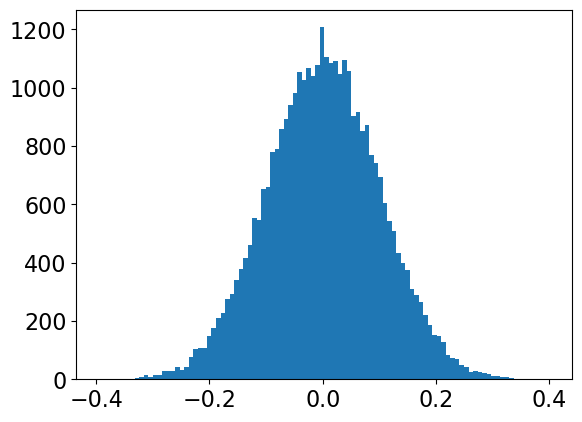

In [32]:
# identity_matrix_ = np.eye(1)
zero_means_ = np.zeros(1)

Wm = np.sqrt(1e2) * diags(np.ones(n_model_samples))

# print('creating s')
s3 = np.random.multivariate_normal(zero_means_, identity_matrix_, size=n_model_samples)

print(s3.shape, Wm.shape)

# perturbed_mod = np.linalg.solve(Wm, s3)
ainv = Solver(Wm)

perturbed_mod = ainv * s3
plt.hist(perturbed_mod, 100)
plt.show()

# # now determine best beta
# dmis_eigen = utils.eigenvalue_by_power_iteration(dmis_rto, rto_model)

# reg_eigen = utils.eigenvalue_by_power_iteration(reg_rto, rto_model)

# ratio = np.asarray(dmis_eigen / reg_eigen)
# beta = 1e-1 * ratio

# print(f'beta is: {beta}')

NameError: name 'data_object' is not defined

IndexError: boolean index did not match indexed array along dimension 0; dimension is 34988 but corresponding boolean dimension is 39736

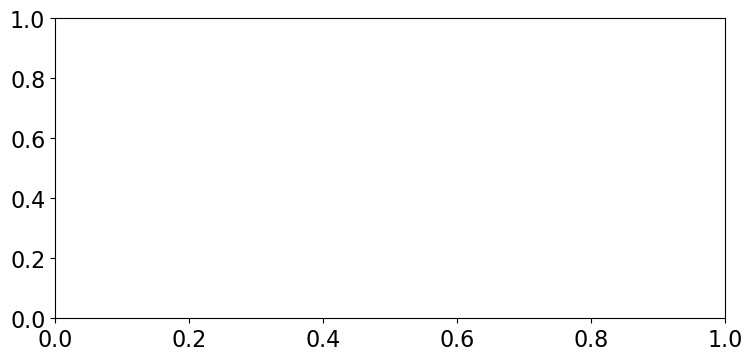

In [35]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_axes([0.15, 0.15, 0.67, 0.75])
mesh.plot_slice(
    rto_model[ind_active],
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    # grid=True,
    clim=(rto_model.min(), rto_model.max()),
    pcolor_opts={"cmap": 'Spectral'},
)
ax1.set_title("Recovered Model - LHS Sampled injections Bayesian inversion")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
# ax1.set_xlim([-1000, 1000])
# ax1.set_ylim([-1000, 0])

# ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
# norm = mpl.colors.Normalize(
#     vmin=rto_model.min(), vmax=true_conductivity_model_log10.max()
# )
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, cmap='Spectral', norm=norm, orientation="vertical", format="$10^{%.1f}$"
# )
# cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)
plt.show()

# print(1 / np.exp(rto_model))

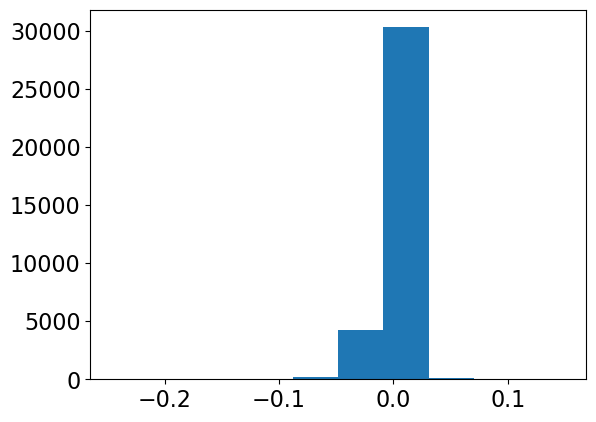

In [29]:
plt.hist(rto_model)
plt.show()

In [193]:
import inspect
def check_derivative(
    fctn,
    x0,
    num=7,
    plotIt=True,
    dx=None,
    expectedOrder=2,
    tolerance=0.85,
    eps=1e-10,
    ax=None,
):
    """Basic derivative check

    Compares error decay of 0th and 1st order Taylor approximation at point
    x0 for a randomized search direction.

    Parameters
    ----------
    fctn : function
        Function handle
    x0 : numpy.ndarray
        Point at which to check derivative
    num : int, optional
        number of times to reduce step length to evaluate derivative
    plotIt : bool, optional
        If *True*, plot the convergence of the approximation of the derivative
    dx : numpy.ndarray, optional
        Step direction. By default, this parameter is set to *None* and a random
        step direction is chosen.
    expectedOrder : int, optional
        The expected order of convergence for the numerical derivative
    tolerance : float, optional
        The tolerance on the expected order
    eps : float, optional
        A threshold value for approximately equal to zero
    ax : matplotlib.pyplot.Axes, optional
        An axis object for the convergence plot if *plotIt = True*.
        Otherwise, the function will create a new axis.

    Returns
    -------
    bool
        Whether you passed the test.

    Examples
    --------
    >>> from discretize import tests, utils
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt

    >>> def simplePass(x):
    ...     return np.sin(x), utils.sdiag(np.cos(x))
    >>> passed = tests.checkDerivative(simplePass, np.random.randn(5))
    ==================== checkDerivative ====================
    iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
    ---------------------------------------------------------
     0   1.00e-01    1.690e-01     8.400e-03      nan
     1   1.00e-02    1.636e-02     8.703e-05      1.985
     2   1.00e-03    1.630e-03     8.732e-07      1.999
     3   1.00e-04    1.629e-04     8.735e-09      2.000
     4   1.00e-05    1.629e-05     8.736e-11      2.000
     5   1.00e-06    1.629e-06     8.736e-13      2.000
     6   1.00e-07    1.629e-07     8.822e-15      1.996
    ========================= PASS! =========================
    Once upon a time, a happy little test passed.
    """

    # matplotlib is a soft dependencies for discretize,
    # lazy-loaded to decrease load time of discretize.
    try:
        import matplotlib
        import matplotlib.pyplot as plt
    except ImportError:
        matplotlib = False

    print("{0!s} checkDerivative {1!s}".format("=" * 20, "=" * 20))
    print(
        "iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order\n{0!s}".format(("-" * 57))
    )

    f0, J0 = fctn(x0)

    # x0 = mkvc(x0)

    if dx is None:
        dx = np.random.randn(1)

    h = np.logspace(-1, -num, num)
    E0 = np.ones(h.shape)
    E1 = np.ones(h.shape)

    def l2norm(x):
        # because np.norm breaks if they are scalars?
        return np.sqrt(np.real(np.vdot(x, x)))

    for i in range(num):
        # Evaluate at test point
        ft, Jt = fctn(x0 + h[i] * dx)
        # 0th order Taylor
        E0[i] = l2norm(ft - f0)
        # 1st order Taylor
        if inspect.isfunction(J0):
            E1[i] = l2norm(ft - f0 - h[i] * J0(dx))
        else:
            # We assume it is a numpy.ndarray
            E1[i] = l2norm(ft - f0 - h[i] * J0.dot(dx))

        order0 = np.log10(E0[:-1] / E0[1:])
        order1 = np.log10(E1[:-1] / E1[1:])
        print(
            " {0:d}   {1:1.2e}    {2:1.3e}     {3:1.3e}      {4:1.3f}".format(
                i, h[i], E0[i], E1[i], np.nan if i == 0 else order1[i - 1]
            )
        )

    # Ensure we are about precision
    order0 = order0[E0[1:] > eps]
    order1 = order1[E1[1:] > eps]
    belowTol = order1.size == 0 and order0.size >= 0
    # Make sure we get the correct order
    correctOrder = order1.size > 0 and np.mean(order1) > tolerance * expectedOrder

    passTest = belowTol or correctOrder

    if passTest:
        print("{0!s} PASS! {1!s}".format("=" * 25, "=" * 25))
        print(happiness[np.random.randint(len(happiness))] + "\n")
    else:
        print(
            "{0!s}\n{1!s} FAIL! {2!s}\n{3!s}".format(
                "*" * 57, "<" * 25, ">" * 25, "*" * 57
            )
        )
        print(sadness[np.random.randint(len(sadness))] + "\n")

    @requires({"matplotlib": matplotlib})
    def plot_it(ax):
        if plotIt:
            if ax is None:
                ax = plt.subplot(111)
            ax.loglog(h, E0, "b")
            ax.loglog(h, E1, "g--")
            ax.set_title(
                "Check Derivative - {0!s}".format(
                    ("PASSED :)" if passTest else "FAILED :(")
                )
            )
            ax.set_xlabel("h")
            ax.set_ylabel("Error")
            leg = ax.legend(
                ["$\mathcal{O}(h)$", "$\mathcal{O}(h^2)$"],
                loc="best",
                title="$f(x + h\Delta x) - f(x) - h g(x) \Delta x - \mathcal{O}(h^2) = 0$",
                frameon=False,
            )
            plt.setp(leg.get_title(), fontsize=15)
            plt.show()

    plot_it(ax)

    return passTest

# from SimPEG import tests
beta_ref = beta_init
passed = check_derivative(
            lambda beta: [dmis_tko(beta), dmis_tko.deriv(beta)], 1e-4, plotIt=True, num=6
        )

self.assertTrue(passed)


==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


ValueError: shapes (34988,) and (1,) not aligned: 34988 (dim 0) != 1 (dim 0)

# Latin hyper cube for 3D inversions

- 2D injections sampled using 2D Latin Hyper cube 

- maybe use this for sampling 3d space. create small manageable meshes and invert many times over these faster pieces.

### load the data and setup simulation

In [25]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TreeMesh
from discretize.utils import refine_tree_xyz, active_from_xyz

from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip_xyz
from SimPEG import (
    data,
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
)

# To plot DC/IP data in 3D, the user must have the plotly package
try:
    import plotly
    from SimPEG.electromagnetics.static.utils.static_utils import plot_3d_pseudosection

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})

# sphinx_gallery_thumbnail_number = 3

# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/dcr3d.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_xyz.txt"
dc_data_filename = dir_path + "dc_data.xyz"

topo_xyz = np.loadtxt(str(topo_filename))

dc_data = read_dcip_xyz(
    dc_data_filename,
    "volt",
    data_header="V/A",
    uncertainties_header="UNCERT",
    is_surface_data=False,
)

# Convert predicted data to apparent conductivities
apparent_conductivity = 1 / apparent_resistivity_from_voltage(
    dc_data.survey,
    dc_data.dobs,
)

if has_plotly:
    fig = plot_3d_pseudosection(
        dc_data.survey,
        apparent_conductivity,
        scale="log",
        units="S/m",
        plane_distance=15,
    )

    fig.update_layout(
        title_text="Apparent Conductivity",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    plotly.io.show(fig)

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

dc_data.standard_deviation = 0.1 * np.abs(dc_data.dobs)

dh = 25.0  # base cell width
dom_width_x = 6000.0  # domain width x
dom_width_y = 6000.0  # domain width y
dom_width_z = 4000.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Mesh refinement based on topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh = refine_tree_xyz(
    mesh, topo_xyz[k, :], octree_levels=[0, 6, 8], method="surface", finalize=False
)

# Mesh refinement near sources and receivers.
electrode_locations = np.r_[
    dc_data.survey.locations_a,
    dc_data.survey.locations_b,
    dc_data.survey.locations_m,
    dc_data.survey.locations_n,
]
unique_locations = np.unique(electrode_locations, axis=0)
mesh = refine_tree_xyz(
    mesh, unique_locations, octree_levels=[4, 6, 4], method="radial", finalize=False
)

# Finalize the mesh
mesh.finalize()

# Find cells that lie below surface topography
ind_active = active_from_xyz(mesh, topo_xyz)

# Extract survey from data object
dc_survey = dc_data.survey

# Shift electrodes to the surface of discretized topography
dc_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

# Reset survey in data object
dc_data.survey = dc_survey

# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = np.log(1e-8)
background_conductivity = np.log(1e-2)

# Define the mapping from active cells to the entire domain
active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())

# Define the mapping from the model to the conductivity of the entire domain
conductivity_map = active_map * maps.ExpMap()

# Define starting model
starting_conductivity_model = background_conductivity * np.ones(nC)

dc_simulation = dc.simulation.Simulation3DNodal(
    mesh, survey=dc_survey, sigmaMap=conductivity_map, solver=Solver, storeJ=True
)

overwriting c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr3d.tar.gz
   saved to: c:\Users\johnk\Documents\git\jresearch\baysian_inversion\dcr3d.tar.gz
Download completed!


- lets now setup a hyper cube sampling the injections

In [2]:
def latin_hypercube_2d_uniform(n):
    lower_limits=-1000 # np.arange(0,n)/n
    upper_limits= 1000 # np.arange(1,n+1)/n

    points=np.random.uniform(low=lower_limits,high=upper_limits,size=[2,n]).T
    np.random.shuffle(points[:,1])
    return points

min_x = unique_locations[:, 0].min()
max_x = unique_locations[:, 0].max()
min_y = unique_locations[:, 1].min()
max_y = unique_locations[:, 1].max()

print(min_x, max_x, min_y, max_y)

-1000.0 1000.0 -1000.0 1000.0


- find the closest injections

In [3]:
from sklearn.neighbors import NearestNeighbors


- now grab those sources and create a sub survey

In [155]:
def create_lhs_subset(

    global_data:data.Data = None,
    n_samples:int = 50,
    verbose:bool = False,

    ):

    # method to spit out samples using hypercube
    n=n_samples
    p=latin_hypercube_2d_uniform(n)

    injection_locations = global_data.survey.locations_a

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(injection_locations[:, :2])
    idx_pick = neigh.kneighbors(p[:, :2])
    picked = injection_locations[idx_pick[1], :]

    down_sampled_sources = []
    down_sampled_data = []
    count_idx = 0
    count_idx_end = 0
    for ii in range(len(dc_data.survey.source_list)):
    # ii = 0
        count_idx_end += len(dc_data.survey.source_list[ii].receiver_list[0].locations[0])
        # print(count_idx, count_idx_end, len(dc_data.survey.source_list[ii].receiver_list[0].locations[0]))
        for jj in range(picked.shape[0]):
            
            if np.array_equal(dc_data.survey.source_list[ii].location[0, :], picked[jj, 0, :]):
                
                down_sampled_sources += [dc_data.survey.source_list[ii]]
                down_sampled_data.append(dc_data.dobs[count_idx:count_idx_end])
                # print("found", ii)
                break

        count_idx = count_idx_end

    survey_lhs = dc.Survey(down_sampled_sources)
    survey_lhs.dobs = np.hstack(down_sampled_data)

    if verbose:
        plt.figure(figsize=[10,10])
        plt.scatter(injection_locations[:,0],injection_locations[:,1],c='r', label='acquisition')
        plt.scatter(p[:,0],p[:,1],c='g', label='LH samples')

        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(injection_locations[:, :2])
        idx_pick = neigh.kneighbors(p[:, :2])
        picked = injection_locations[idx_pick[1], :]
        plt.plot(picked[:,0, 0], picked[:,0, 1], 'dk', label='nearest injections to LH samples')
        plt.xlabel('easting (m)')
        plt.ylabel('northing (m)')
        plt.title('Sampled injections')
        plt.legend()
        plt.grid(True)
        plt.show()

    return survey_lhs


class betaInvProblem(inverse_problem.BaseInvProblem):

    def evalFunction(self, m, return_g=True, return_H=True):
        """evalFunction(m, return_g=True, return_H=True)"""

        self.model = m
        gc.collect()

        # Store fields if doing a line-search
        f = self.getFields(m, store=(return_g is False and return_H is False))

        # if isinstance(self.dmisfit, BaseDataMisfit):
        tko_d = self.dmisfit(m, f=f)
        self.dpred = self.get_dpred(m, f=f)

        beta_prior = self.reg(m)

        phi = tko_d + beta_prior

        out = (phi,)
        if return_g:
            phi_dDeriv = self.dmisfit.deriv(m, f=f)
            phi_mDeriv = self.reg.deriv(m)

            g = phi_dDeriv + phi_mDeriv
            out += (g,)

        if return_H:

            def H_fun(v):
                phi_d2Deriv = self.dmisfit.deriv2(m, v, f=f)
                phi_m2Deriv = self.reg.deriv2(m, v=v)

                return phi_d2Deriv + phi_m2Deriv

            H = sp.linalg.LinearOperator((m.size, m.size), H_fun, dtype=m.dtype)
            out += (H,)
        return out if len(out) > 1 else out[0]

class L2BetaMisfit(data_misfit.BaseDataMisfit):
    r"""
    The data misfit with an l_2 norm:

    .. math::

        \mu_\text{data} =
            \frac{1}{2}
            \left|
                \mathbf{W}_d (\mathbf{d}_\text{pred} - \mathbf{d}_\text{obs})
            \right|_2^2
    """

    # @timeIt
    def __call__(self, beta, f=None):
        "__call__(m, f=None)"

        xi = np.sqrt(beta_ref / beta)
        R = self.W * self.residual(xi, f=f)
        return 0.5 * np.vdot(R, R)

    # @timeIt
    def deriv(self, beta, f=None):
        r"""
        Derivative of the data misfit

        .. math::

            \mathbf{J}^{\top} \mathbf{W}^{\top} \mathbf{W}
            (\mathbf{d} - \mathbf{d}^{obs})

        :param numpy.ndarray m: model
        :param SimPEG.fields.Fields f: fields object
        """

        xi = np.sqrt(beta_ref / beta) * m
        d_xi = -0.5 * np.sqrt(beta_ref) * np.sqrt(beta)**-3 * m

        if f is None:
            f = self.simulation.fields(xi)

        return self.simulation.Jtvec(
            xi, * d_xi * self.W.T * (self.W * self.residual(xi, f=f)), f=f
        )

In [126]:
# import dask
# import distributed
# model zero mean guassian distribution
n_model_samples = mesh.nC
identity_matrix = np.eye(n_model_samples)
zero_means = np.zeros(n_model_samples)

starting_model = starting_conductivity_model.copy()

beta_init = 1e-6
mu_init = 20

initial_x = starting_model
result = []
ii = 0

# coefficient matrix
# Wm = np.sqrt(beta_perturb) * np.eye(n_model_samples)

# solve linear equation for perturbed model
# draw from perturbed model distribution
# draws = []
draws_mu = []
TKO = False

while ii < 15:

    # create lhs subsampling
    survey_sub = create_lhs_subset(dc_data)
    uncert = np.abs(survey_sub.dobs * 0.05)
    dobs_sub=data.Data(survey_sub, dobs=survey_sub.dobs, standard_deviation=uncert)

    dobs_sub.standard_deviation = 0.1 * np.abs(dobs_sub.dobs)

    # sub simulation
    dc_sub_simulation = dc.simulation.Simulation3DNodal(
        mesh, survey=survey_sub, sigmaMap=conductivity_map, solver=Solver, storeJ=False
    )

    # Define the data misfit. Here the data misfit is the L2 norm of the weighted
    # residual between the observed data and the data predicted for a given model.
    # Within the data misfit, the residual between predicted and observed data are
    # normalized by the data's standard deviation.
    dmis_rto = data_misfit.L2DataMisfit(data=dobs_sub, simulation=dc_sub_simulation)

    # Optimization
    opt = optimization.ProjectedGNCG(maxIter=9, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=12, )
    opt.remember('xc')

    # Define the regularization (model objective function)
    # reg_rto = regularization.WeightedLeastSquares(
    #     mesh, alpha_s=1e-2, alpha_x=1, reference_model=perturbed_model[:, 0]
    # )
    # Define the regularization (model objective function)
    reg_rto = regularization.WeightedLeastSquares(
        mesh,
        indActive=ind_active,
        reference_model=starting_conductivity_model,
    )

    reg_rto.reference_model_in_smooth = (
        True  # Include reference model in smoothness
    )
    # reg_rto.cell_weights = jweights * mesh.vol[ind_active]
    # reg_rto = regularization.Sparse(
    #     mesh, alpha_s=1, alpha_x=1e-2, reference_model=perturbed_model[:, 0]
    # )

    jtj_diag = dc_sub_simulation.getJtJdiag(initial_x, W=dmis_rto.W)

    # Compute and sum root-mean squared sensitivities for all objective functions
    wr = np.zeros_like(initial_x)
    wr += reg_rto.mapping.deriv(initial_x).T * (
        (reg_rto.mapping * jtj_diag) / reg_rto.regularization_mesh.vol**2.0
    )
    threshold_value = 1e-3
    wr **= 0.5

    # Apply thresholding
    wr = np.clip(wr, a_min=threshold_value * wr.max(), a_max=np.inf)

    # Apply normalization
    # if self.normalization_method == "maximum":
    wr /= wr.max()
    reg_rto.cell_weights = wr
    # elif self.normalization_method == "minimum":
    #     wr /= wr.min()


    # Set the inverse problem
    invProb = inverse_problem.BaseInvProblem(dmis_rto,  reg_rto,  opt)
    invProb.startup(initial_x)
    invProb.beta = beta_init

    # print(reg_rto(initial_x), dmis_rto(initial_x))

    rto_model = opt.minimize(invProb.evalFunction, initial_x)

    # rto_model = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
    # tko
    # if tko:

    #     # create the beta misfit object
    #     beta_misfit = L2BetaMisfit(data=dobs_sub, simulation=dc_sub_simulation)

    #     # initiate beta prior
        

    #     # create new inverse problem

    result.append(rto_model)

    ii += 1

# while ii < 500:

#     perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)[0, :]
#     data_object = data.Data(survey, dobs=perturbed_data, standard_deviation=std)

#     s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)
#     perturbed_model = np.linalg.solve(Wm, s.T)

#     # Define the data misfit. Here the data misfit is the L2 norm of the weighted
#     # residual between the observed data and the data predicted for a given model.
#     # Within the data misfit, the residual between predicted and observed data are
#     # normalized by the data's standard deviation.
#     dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

#     # Define the regularization (model objective function)
#     reg_rto = regularization.WeightedLeastSquares(
#         mesh, alpha_s=1e-2, alpha_x=1, reference_model=perturbed_model[:, 0]
#     )

#     request = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)

#     ii += 1
#     if request is not None:
        
#         futures += [request]

#     else:

#         # processed time series hdf5 already exists, yay
#         pass

# dps = client.compute(futures)

# dps_gather = client.gather(dps)



C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  3.69e+03    4.68e+02      0              
   1  1.72e+02    5.48e+01      0              
   2  1.30e+01    4.69e+00      0   Skip BFGS  
   3  7.42e+00    2.43e+00      0   Skip BFGS  
   4  5.89e+00    1.71e+00      0              
   5  4.48e+00    1.43e+00      0   Skip BFGS  
   6  4.09e+00    6.64e-01      0              
   7  3.89e+00    8.16e-01      0              
   8  3.64e+00    9.08e-01      0              
   9  3.50e+00    3.63e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.4107e-01 <= tolF*(1+|f0|) = 3.6875e+02
1 : |xc-x_last| = 2

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  1.85e+03    2.78e+02      0              
   1  8.68e+01    3.09e+01      0              
   2  1.40e+01    5.64e+00      0   Skip BFGS  
   3  6.00e+00    2.85e+00      0   Skip BFGS  
   4  4.19e+00    1.50e+00      0              
   5  3.15e+00    1.05e+00      0              
   6  2.84e+00    7.10e-01      0              
   7  2.68e+00    5.82e-01      0              
   8  2.60e+00    5.23e-01      0              
   9  2.58e+00    6.82e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.2446e-02 <= tolF*(1+|f0|) = 1.8551e+02
1 : |xc-x_last| = 4

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.87e+03    4.08e+02      0              
   1  1.28e+02    4.41e+01      0              
   2  1.42e+01    4.94e+00      0   Skip BFGS  
   3  7.29e+00    2.96e+00      0   Skip BFGS  
   4  5.54e+00    1.69e+00      0              
   5  4.29e+00    1.35e+00      0   Skip BFGS  
   6  3.97e+00    5.95e-01      0              
   7  3.80e+00    8.21e-01      0              
   8  3.61e+00    6.94e-01      0              
   9  3.43e+00    4.05e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.8189e-01 <= tolF*(1+|f0|) = 2.8727e+02
1 : |xc-x_last| = 3

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.39e+03    3.88e+02      0              
   1  1.22e+02    4.60e+01      0              
   2  1.04e+01    4.32e+00      0   Skip BFGS  
   3  6.33e+00    2.76e+00      0   Skip BFGS  
   4  5.09e+00    1.65e+00      0              
   5  4.03e+00    8.98e-01      0              
   6  3.77e+00    6.76e-01      0              
   7  3.66e+00    5.40e-01      0              
   8  3.59e+00    5.97e-01      0              
   9  3.58e+00    7.33e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.8217e-02 <= tolF*(1+|f0|) = 2.3958e+02
1 : |xc-x_last| = 4

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.71e+03    4.26e+02      0              
   1  1.44e+02    5.10e+01      0              
   2  1.12e+01    4.72e+00      0   Skip BFGS  
   3  6.72e+00    2.05e+00      0   Skip BFGS  
   4  5.61e+00    1.64e+00      0              
   5  4.59e+00    1.21e+00      0   Skip BFGS  
   6  4.24e+00    7.20e-01      0              
   7  4.01e+00    8.59e-01      0              
   8  3.59e+00    1.28e+00      0              
   9  3.30e+00    4.32e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.8739e-01 <= tolF*(1+|f0|) = 2.7077e+02
1 : |xc-x_last| = 4

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.91e+03    4.52e+02      0              
   1  1.47e+02    5.52e+01      0              
   2  9.52e+00    4.83e+00      0   Skip BFGS  
   3  5.09e+00    2.08e+00      0   Skip BFGS  
   4  4.04e+00    1.43e+00      0              
   5  3.28e+00    9.79e-01      0   Skip BFGS  
   6  3.07e+00    6.01e-01      0              
   7  2.95e+00    6.41e-01      0              
   8  2.81e+00    6.23e-01      0              
   9  2.72e+00    2.89e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 8.0613e-02 <= tolF*(1+|f0|) = 2.9139e+02
1 : |xc-x_last| = 1

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.28e+03    3.44e+02      0              
   1  1.13e+02    4.08e+01      0              
   2  9.73e+00    4.93e+00      0   Skip BFGS  
   3  5.21e+00    1.81e+00      0   Skip BFGS  
   4  4.00e+00    1.36e+00      0              
   5  3.13e+00    1.02e+00      0   Skip BFGS  
   6  2.90e+00    6.35e-01      0              
   7  2.77e+00    6.74e-01      0              
   8  2.55e+00    8.43e-01      0              
   9  2.40e+00    3.97e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.4807e-01 <= tolF*(1+|f0|) = 2.2782e+02
1 : |xc-x_last| = 2

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.15e+03    3.83e+02      0              
   1  1.05e+02    4.83e+01      0              
   2  9.96e+00    5.57e+00      0   Skip BFGS  
   3  6.00e+00    2.36e+00      0   Skip BFGS  
   4  4.86e+00    1.73e+00      0              
   5  3.79e+00    1.26e+00      0              
   6  3.48e+00    6.59e-01      0              
   7  3.35e+00    5.87e-01      0              
   8  3.28e+00    5.37e-01      0              
   9  3.26e+00    6.30e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.5681e-02 <= tolF*(1+|f0|) = 2.1511e+02
1 : |xc-x_last| = 5

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.69e+03    4.45e+02      0              
   1  1.12e+02    4.41e+01      0              
   2  1.41e+01    5.86e+00      0   Skip BFGS  
   3  6.50e+00    2.30e+00      0   Skip BFGS  
   4  5.29e+00    1.20e+00      0              
   5  4.49e+00    1.26e+00      0   Skip BFGS  
   6  4.13e+00    6.62e-01      0              
   7  3.92e+00    8.48e-01      0              
   8  3.67e+00    9.16e-01      0              
   9  3.43e+00    4.80e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.3855e-01 <= tolF*(1+|f0|) = 2.6928e+02
1 : |xc-x_last| = 4

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  2.99e+03    4.22e+02      0              
   1  1.36e+02    4.57e+01      0              
   2  1.12e+01    4.52e+00      0   Skip BFGS  
   3  5.71e+00    2.00e+00      0   Skip BFGS  
   4  4.62e+00    1.23e+00      0              
   5  3.74e+00    9.54e-01      0   Skip BFGS  
   6  3.49e+00    5.18e-01      0              
   7  3.34e+00    6.83e-01      0              
   8  3.12e+00    8.27e-01      0              
   9  2.91e+00    4.20e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.1311e-01 <= tolF*(1+|f0|) = 2.9925e+02
1 : |xc-x_last| = 4

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  4.54e+03    5.46e+02      0              
   1  1.81e+02    5.45e+01      0              
   2  2.83e+01    8.77e+00      0   Skip BFGS  
   3  1.29e+01    4.41e+00      0              
   4  8.11e+00    2.13e+00      0              
   5  6.58e+00    1.63e+00      0              
   6  6.02e+00    1.05e+00      0              
   7  5.80e+00    9.70e-01      0              
   8  5.77e+00    1.09e+00      0              
   9  5.70e+00    1.27e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.8026e-02 <= tolF*(1+|f0|) = 4.5383e+02
1 : |xc-x_last| = 7

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  3.58e+03    4.68e+02      0              
   1  1.47e+02    5.23e+01      0              
   2  1.15e+01    5.00e+00      0   Skip BFGS  
   3  5.87e+00    2.65e+00      0   Skip BFGS  
   4  4.67e+00    1.47e+00      0              
   5  3.67e+00    1.31e+00      0   Skip BFGS  
   6  3.29e+00    7.21e-01      0              
   7  3.06e+00    8.40e-01      0              
   8  2.73e+00    1.05e+00      0              
   9  2.48e+00    4.91e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.4926e-01 <= tolF*(1+|f0|) = 3.5815e+02
1 : |xc-x_last| = 4

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  3.73e+03    5.50e+02      0              
   1  1.89e+02    5.89e+01      0              
   2  2.77e+01    7.58e+00      0   Skip BFGS  
   3  1.20e+01    5.91e+00      0   Skip BFGS  
   4  7.31e+00    2.54e+00      0              
   5  5.35e+00    1.51e+00      0              
   6  4.91e+00    8.87e-01      0              
   7  4.73e+00    8.16e-01      0              
   8  4.64e+00    6.82e-01      0              
   9  4.61e+00    9.41e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.5205e-02 <= tolF*(1+|f0|) = 3.7335e+02
1 : |xc-x_last| = 5

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  3.13e+03    4.79e+02      0              
   1  1.75e+02    6.00e+01      0              
   2  1.24e+01    5.93e+00      0   Skip BFGS  
   3  6.31e+00    2.56e+00      0   Skip BFGS  
   4  4.99e+00    1.58e+00      0              
   5  4.00e+00    9.66e-01      0              
   6  3.71e+00    8.30e-01      0              
   7  3.56e+00    5.87e-01      0              
   8  3.43e+00    7.29e-01      0              
   9  3.40e+00    7.70e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.8354e-02 <= tolF*(1+|f0|) = 3.1274e+02
1 : |xc-x_last| = 7

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:55: DeprecationWarning:

The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\33956939.py:85: FutureWarning:

cell_weights are deprecated please access weights using the `set_weights`, `get_weights`, and `remove_weights` functionality. This will be removed in 0.19.0




                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
================ Projected GNCG ================
  #      f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------
x0 has any nan: 0
   0  4.63e+03    5.75e+02      0              
   1  2.26e+02    6.92e+01      0              
   2  1.56e+01    7.18e+00      0   Skip BFGS  
   3  7.64e+00    2.71e+00      0   Skip BFGS  
   4  6.15e+00    1.80e+00      0              
   5  4.67e+00    1.52e+00      0   Skip BFGS  
   6  4.29e+00    7.95e-01      0              
   7  4.09e+00    8.44e-01      0              
   8  3.81e+00    1.07e+00      0              
   9  3.62e+00    5.05e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.8873e-01 <= tolF*(1+|f0|) = 4.6321e+02
1 : |xc-x_last| = 2

$$\mathbf{J}^{\top} \mathbf{W}^{\top} \mathbf{W}
            (\mathbf{d} - \mathbf{d}^{obs})$$

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\2475362108.py:13: FutureWarning:

getIndicesSphere has been deprecated, please use get_indices_sphere. It will be removed in version 0.19.0 of SimPEG.

C:\Users\johnk\AppData\Local\Temp\ipykernel_25772\2475362108.py:18: FutureWarning:

getIndicesSphere has been deprecated, please use get_indices_sphere. It will be removed in version 0.19.0 of SimPEG.



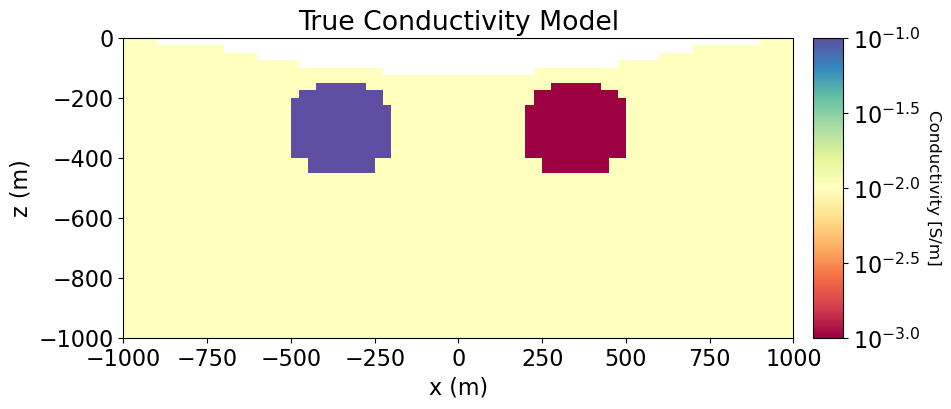

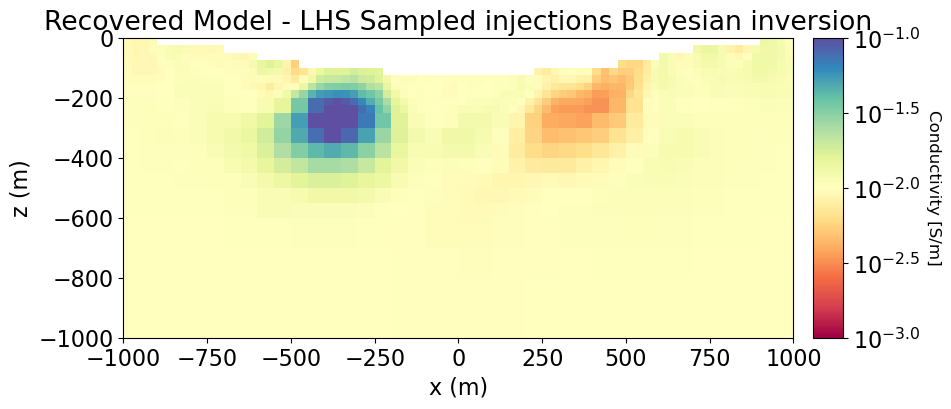

In [136]:
# result.append(rto_model)
recovered_conductivity_model = np.median(np.vstack(result), axis=0)
# print(recovered_conductivity_model)

# Define conductivity model in S/m (or resistivity model in Ohm m)
background_value = 1e-2
conductor_value = 1e-1
resistor_value = 1e-3

# Define model
true_conductivity_model = background_value * np.ones(nC)

ind_conductor = model_builder.getIndicesSphere(
    np.r_[-350.0, 0.0, -300.0], 160.0, mesh.cell_centers[ind_active, :]
)
true_conductivity_model[ind_conductor] = conductor_value

ind_resistor = model_builder.getIndicesSphere(
    np.r_[350.0, 0.0, -300.0], 160.0, mesh.cell_centers[ind_active, :]
)
true_conductivity_model[ind_resistor] = resistor_value
true_conductivity_model_log10 = np.log10(true_conductivity_model)

# Plot True Model
fig = plt.figure(figsize=(10, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.15, 0.15, 0.67, 0.75])
mesh.plot_slice(
    plotting_map * true_conductivity_model_log10,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=False,
    clim=(true_conductivity_model_log10.min(), true_conductivity_model_log10.max()),
    pcolor_opts={"cmap": 'Spectral'},
)
ax1.set_title("True Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1000, 1000])
ax1.set_ylim([-1000, 0])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
norm = mpl.colors.Normalize(
    vmin=true_conductivity_model_log10.min(), vmax=true_conductivity_model_log10.max()
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap='Spectral', norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

# Plot recovered model
recovered_conductivity_model_log10 = np.log10(np.exp(recovered_conductivity_model))

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_axes([0.15, 0.15, 0.67, 0.75])
mesh.plot_slice(
    plotting_map * recovered_conductivity_model_log10,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    # grid=True,
    clim=(true_conductivity_model_log10.min(), true_conductivity_model_log10.max()),
    pcolor_opts={"cmap": 'Spectral'},
)
ax1.set_title("Recovered Model - LHS Sampled injections Bayesian inversion")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1000, 1000])
ax1.set_ylim([-1000, 0])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
norm = mpl.colors.Normalize(
    vmin=true_conductivity_model_log10.min(), vmax=true_conductivity_model_log10.max()
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap='Spectral', norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)
plt.show()

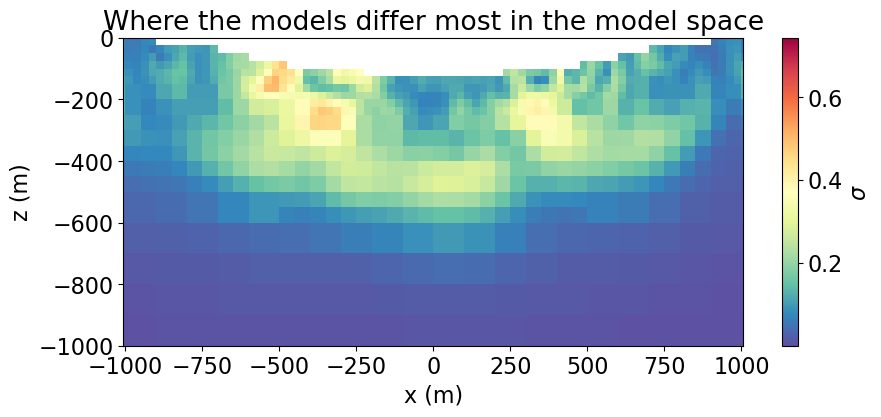

In [141]:
# plt.hist(np.vstack(result).std(axis=0))
fig, ax2 = plt.subplots(1, figsize=(10, 4))
vmin=np.vstack(result).std(axis=0).min()
vmax=np.vstack(result).std(axis=0).max()

Im = mesh.plot_slice(
    plotting_map * np.vstack(result).std(axis=0),
    ax=ax2,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=False,
    clim=(vmin, vmax),
    pcolor_opts={"cmap": 'Spectral_r'},
)

ax2.set_title("Where the models differ most in the model space")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")

ax2.axis("equal")
ax2.set_xlim([-1000, 1000])
ax2.set_ylim([-1000, 0])

plt.colorbar(Im[0], label='$\sigma$')

plt.show()

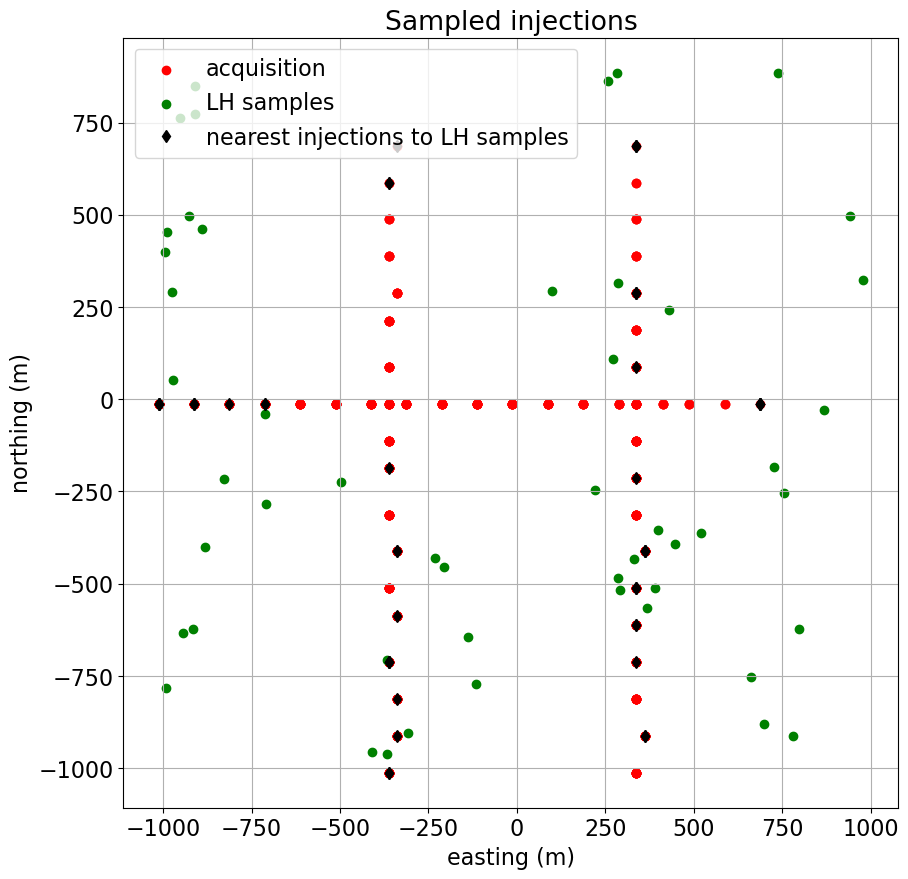

In [156]:
survey_sub = create_lhs_subset(dc_data, verbose=True)

## Something else

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Define your likelihood function
def log_likelihood(params, data):
    # Assume a simple Gaussian likelihood
    mu = params[0]
    sigma = params[1]
    return -0.5 * np.sum((data - mu)**2 / sigma**2)

# Define your prior function
def log_prior(params):
    # Assume uniform priors for mu and sigma
    mu = params[0]
    sigma = params[1]
    if 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the total log-probability function
def log_probability(params, data):
    lp = log_prior(params)
    if np.isinf(lp):
        return -np.inf
    return lp + log_likelihood(params, data)

# Generate synthetic data
np.random.seed(42)
true_mu = 3.0
true_sigma = 1.0
data = np.random.normal(true_mu, true_sigma, size=100)

# Latin Hypercube Sampling
def latin_hypercube_samples(n_samples, n_dim):
    lhs = np.linspace(0, 1, n_samples + 1)
    np.random.shuffle(lhs)
    samples = np.zeros((n_samples, n_dim))
    for i in range(n_dim):
        samples[:, i] = np.random.uniform(lhs[:-1], lhs[1:], size=n_samples)
    return samples

# Initialize parameters
n_walkers = 32
n_dim = 1
n_steps = 1000

# Generate Latin Hypercube samples
lhs_samples = latin_hypercube_samples(n_walkers, n_dim)
print(lhs_samples)
# Initialize walkers around the LHS samples
initial_positions = lhs_samples + 1e-3 * np.random.randn(n_walkers, n_dim)

# Initialize storage for chain
chain = np.empty((n_walkers, n_steps, n_dim))
chain[:, 0, :] = initial_positions

# MCMC sampling
for step in range(1, n_steps):
    for walker in range(n_walkers):
        old_params = chain[walker, step - 1, :]
        new_params = old_params + 1e-2 * np.random.randn(n_dim)
        log_prob_old = log_probability(old_params, data)
        log_prob_new = log_probability(new_params, data)
        acceptance_ratio = np.exp(log_prob_new - log_prob_old)
        if np.random.uniform() < acceptance_ratio:
            chain[walker, step, :] = new_params
        else:
            chain[walker, step, :] = old_params

# Plot the results
fig, axes = plt.subplots(n_dim, figsize=(8, 6), sharex=True)
samples = chain[:, 200:, :].reshape((-1, n_dim))
for i in range(n_dim):
    axes[i].hist(samples[:, i], bins=30, density=True, color="b", alpha=0.7)
    axes[i].set_ylabel("Density")
    axes[i].set_xlabel(f"Parameter {i+1}")
plt.tight_layout()
plt.show()



[[0.77767798]
 [0.52308558]
 [0.69079601]
 [0.40804369]
 [0.34573618]
 [0.11424153]
 [0.54596165]
 [0.70977852]
 [0.43989859]
 [0.33548645]
 [0.27620221]
 [0.55531266]
 [0.85045775]
 [0.94032156]
 [0.21175711]
 [0.05247562]
 [0.06039352]
 [0.21298446]
 [0.70170757]
 [0.54030445]
 [0.50155511]
 [0.8017878 ]
 [0.92214208]
 [0.51511845]
 [0.48654056]
 [0.45964835]
 [0.31957904]
 [0.54470531]
 [0.48514447]
 [0.04263329]
 [0.21365119]
 [0.29941981]]


IndexError: index 1 is out of bounds for axis 0 with size 1

## 2D

-15.0 15 -15.0 0.0


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\mixins\mpl_mod.py:302: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


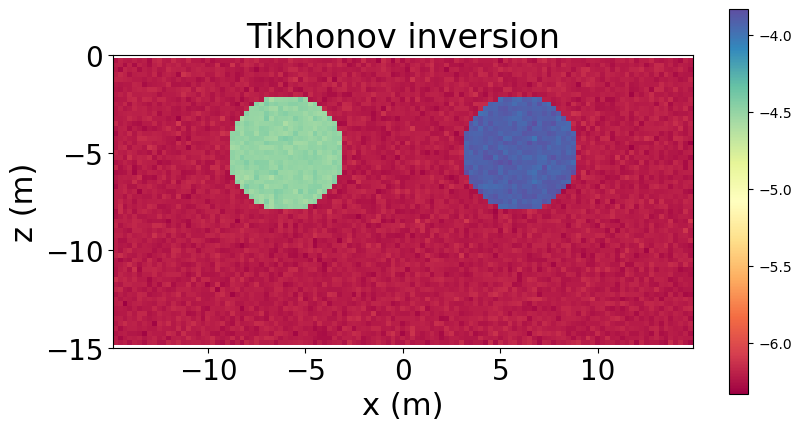

In [4]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as DCUtils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
import copy

# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))


mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

clim = [mtrue.min(), mtrue.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue[actcore], ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0])
plt.show()

In [5]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive
sim = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)

std = 0.02

simulation_data = sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)
survey.eps = 1e-6

m0 = -np.log(np.median((DCUtils.apparent_resistivity_from_voltage(survey, simulation_data.dobs)))) * np.ones(mapping.nP)

c:\users\johnk\documents\github\simpeg_jk\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
c:\users\johnk\documents\github\simpeg_jk\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


# sampling 2d problem

In [8]:
initial_x = m0
data_object_hmc = data.Data(survey, dobs=simulation_data.dobs.copy(), standard_deviation=std)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_hmc = data_misfit.L2DataMisfit(simulation=sim, data=data_object_hmc)

# Define the regularization (model objective function)
reg_hmc = regularization.Sparse(
    mesh, alpha_s=1, alpha_x=1, active_cells=actcore,
)

reg_hmc.reference_model_in_smooth = (
    True  # Include reference model in smoothness
)
# reg_rto.cell_weights = jweights * mesh.vol[ind_active]
# reg_rto = regularization.Sparse(
#     mesh, alpha_s=1, alpha_x=1e-2, reference_model=perturbed_model[:, 0]
# )

# jtj_diag = sim.getJtJdiag(initial_x, W=dmis_hmc.W)

# # Compute and sum root-mean squared sensitivities for all objective functions
# wr = np.zeros_like(initial_x)
# wr += reg_hmc.mapping.deriv(initial_x).T * (
#     (reg_hmc.mapping * jtj_diag) / reg_hmc.regularization_mesh.vol**2.0
# )
# threshold_value = 1e-3
# wr **= 0.5

# # Apply thresholding
# wr = np.clip(wr, a_min=threshold_value * wr.max(), a_max=np.inf)

# # Apply normalization
# # if self.normalization_method == "maximum":
# wr /= wr.max()
# reg_hmc.cell_weights = wr
# elif self.normalization_method == "minimum":
#     wr /= wr.min()
# reg_hmc.beta = 1e-4
# Optimization
opt = optimization.ProjectedGNCG(maxIter=9, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=12, )
opt.remember('xc')

dmis_eigen = utils.eigenvalue_by_power_iteration(dmis_hmc, initial_x)

reg_eigen = utils.eigenvalue_by_power_iteration(reg_hmc, initial_x)

ratio = np.asarray(dmis_eigen / reg_eigen)
beta0 = 1e-1 * ratio


# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis_hmc,  reg_hmc,  opt)
invProb.startup(initial_x)
invProb.beta = beta0

from scipy import stats

def hmc(inv_prob, n_samples, x0, n_leap_frog=4 ,step_size=0.25, p_std=1):

    samples = [x0, ]
    M = np.diag(p_std**2 * np.ones_like(x0))
    momentum_dist = stats.multivariate_normal(mean=np.zeros_like(x0), cov=M)
    M_inv = 1/p_std**2 * np.ones_like(x0)
    
    n_accept = 0 
    x0_nlp = inv_prob.evalFunction(x0, return_g=False, return_H=False)
    # deriv = d_neg_log_func(samples[0])
    # x0_nlp = neg_log_func(samples[0])
    for i in range(n_samples):
        x0 = samples[-1]
        x1 = x0.copy()
        
        p0 = momentum_dist.rvs()
        p1 = p0.copy()

        # leapfrog integration begin
        _, deriv = inv_prob.evalFunction(x1, return_H=False)   # d_neg_log_func(x1)
        for s in range(n_leap_frog):
            p1 -= step_size * -deriv/2
            x1 += step_size * M_inv * p1
            _, deriv = inv_prob.evalFunction(x1, return_H=False)
            p1 -= step_size * -deriv/2
        # leapfrog integration end
        p1 *= -1
        # reverse momentum at the final location for reversibility
        # In this case the momentum distribution is symmetric, so it doesn't matter...

        #metropolis acceptance
        x1_nlp = inv_prob.evalFunction(x1, return_g=False, return_H=False)  # neg_log_func(x1)
        
        p0_nlp = -momentum_dist.logpdf(p0)
        p1_nlp = -momentum_dist.logpdf(p1)
        
        # Account for negatives AND log(probabiltiies)...
        target = -x0_nlp + x1_nlp # f(x1)/f(x0)
        adjustment = p0_nlp - p1_nlp # g(p1)/g(p0)
        acceptance = target + adjustment # rf * rg
        print(f"acceptance: {acceptance}, {np.log(np.random.random())}")
        # if np.log(np.random.random()) <= acceptance:
        #     samples.append(x1)
        #     x0_nlp = x1_nlp
        #     n_accept += 1
        # else:
        samples.append(x1)

    return np.array(samples), n_accept


samples, n_accept = hmc(
    invProb, n_samples=1, x0=m0, n_leap_frog=3 ,step_size=0.1
)
print(n_accept)
hmc_result = samples

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


c:\users\johnk\documents\github\simpeg_jk\SimPEG\maps.py:1903: RuntimeWarning: overflow encountered in exp
  return np.exp(mkvc(m))


acceptance: -3.389700328718406e+17, -0.8790919614018171
0


In [1]:
dmis_eigen = utils.eigenvalue_by_power_iteration(dmis_hmc, initial_x)

reg_eigen = utils.eigenvalue_by_power_iteration(reg_hmc, initial_x)

ratio = np.asarray(dmis_eigen / reg_eigen)
beta0 = 1e-1 * ratio
print(beta0)

NameError: name 'utils' is not defined

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


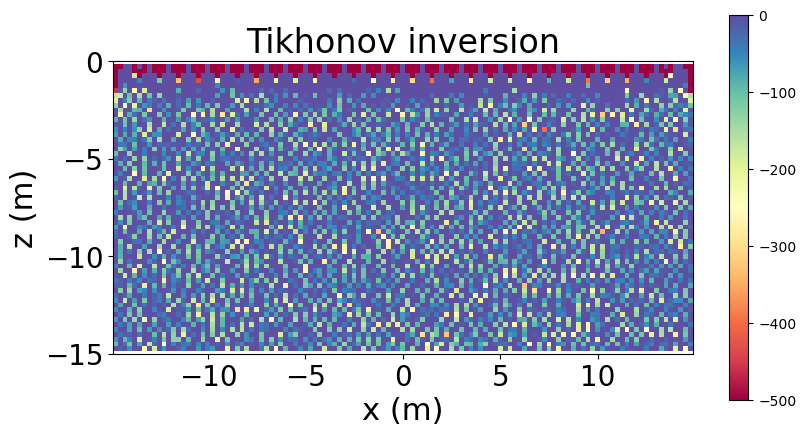

In [9]:
mopt = np.vstack(samples).mean(axis=0)
# Plot the recovered model
clim = [-500, 0]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mopt, ax=ax, clim=clim, pcolor_opts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

In [209]:
mopt.max()

-5.510532599640173